# Notebook description

Preprocessing performed: temporal aggregation, normalization, splitting. Preprocessed and splitted object are then saved

***PS: All the procedures and functions have been built in a general way adaptable for a many-to-many scenario.***

In [1]:
!python --version # Python 3.10.12

Python 3.10.12


# Libraries

In [2]:
#!pip install --upgrade tensorflow[and-cuda] #tensorflow[and-cuda]

!pip install numpy==1.25.2
!pip install rioxarray==0.15.5
!pip install matplotlib==3.7.1
!pip install xarray==2023.7.0
!pip install netCDF4==1.6.5
!pip install pandas==2.0.3
!pip install seaborn==0.13.1
!pip install rasterio==1.3.10
!pip install imageio==2.31.6
!pip install geopandas==0.13.2
!pip install cmasher==1.8.0
!pip install adjustText==1.1.1
!pip install scipy==1.11.4

!pip install cftime==1.6.3
!pip install great-circle-calculator==1.3.1
!pip install matplotlib_scalebar==0.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 488.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: cftime
    Found existing installation: cftime 1.6.4
    Uninstalling cftime-1.6.4:
      Successfully uninstalled cftime-1.6.4


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import rioxarray
from netCDF4 import num2date
import rasterio
from rasterio.plot import show
import pandas as pd
import copy
import datetime
from datetime import datetime, timedelta
import seaborn as sns
import geopandas as gpd
import datetime
import os
from itertools import compress
import random
import re
import math
import gc
import scipy.stats
from sklearn.preprocessing import OneHotEncoder
import warnings
import sys

# Drive, directories, and modules

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [10]:
## Define your directories

data_path = "/.../Datasets/"
## subfolder in /datasets
meteo_data_path = data_path + "Meteo_OI_ARPA/"
shapefile_path = data_path + "shapefile_raster/"
water_table_time_series_path = data_path + "water_table_ARPA_GranaMaira/"
# Saving preprocessed data
saving_pre_proc_GM_meteo_path = data_path + "pre_processed_meteoOI_ARPA_Grana_Maira/"
saving_pre_proc_GM_water_table_path = data_path + "pre_processed_water_table_Grana_Maira/"
saving_split_path = data_path + "training_validation_test_sets_2Y/"
saving_split_path_target = saving_split_path + "target_water_table_depth/"
saving_split_path_features = saving_split_path + "features_meteorological_variables/"

# results saving path
plot_path = "/.../Results/water_table_Grana_Maira/"


In [6]:
# Import modules
sys.path.append('/.../python_modules/')

from data_handle import *
from plot_functions import *

# Data loading

All the time series for the Grana Maira catchemnt are stored in single .csv file. We upload all of them in a dictionary and preprocessing step are applied on all of them.
Meteorological data are stored in a NetCDF file already clipped on the study region.

#### Water table data

In [11]:
# Retrieve all file names of the time series
water_table_time_series_path_file_names = select_file_names(water_table_time_series_path, "Water_Table_Depth_Grana_Maira"); water_table_time_series_path_file_names

['Savigliano_00421510001_Water_Table_Depth_Grana_Maira.csv',
 'Vottignasco_00425010001_Water_Table_Depth_Grana_Maira.csv',
 'Racconigi_00417910001_Water_Table_Depth_Grana_Maira.csv']

In [12]:
# Retrieve printable titles for subsequent plot

sensor_titles = [water_table_time_series_path_file_names[i].replace("_", " ") for i in range(0,len(water_table_time_series_path_file_names))]
sensor_titles = [sensor_titles[i].replace(" 09 05 2024", "") for i in range(0,len(water_table_time_series_path_file_names))]
sensor_titles = [sensor_titles[i].replace(".csv", "") for i in range(0,len(sensor_titles))]
sensor_titles = [sensor_titles[i].replace(" Grana Maira", "") for i in range(0,len(sensor_titles))]
sensor_titles

['Savigliano 00421510001 Water Table Depth',
 'Vottignasco 00425010001 Water Table Depth',
 'Racconigi 00417910001 Water Table Depth']

In [13]:
# Retrieve the municipality for each sensor - again for printing purposes

sensor_municipalities_id_codes = [sensor_titles[i].replace(" Water Table Depth", "") for i in range(0,len(sensor_titles))]
sensor_municipalities_id_codes

['Savigliano 00421510001', 'Vottignasco 00425010001', 'Racconigi 00417910001']

In [14]:
# Load all the time series in a dictionary, whose keys are the identification code of each sensor
# sensor_id_list a list with the keys of the dictionary

wt_depth_all_time_series = load_ts_in_dictionary(directory = water_table_time_series_path,
                                                       list_name = water_table_time_series_path_file_names,
                                                       sep = ",",
                          sensor_identifier = "ID_code",
                          data_type_specification = {'Date':'datetime64[ns]'},
                          validated_value_name = "Value",
                          to_eng_decimal_delimiter = False)

In [15]:
sensor_id_list = list(wt_depth_all_time_series.keys()); sensor_id_list

['00421510001', '00425010001', '00417910001']

#### Meteorological variables

In [16]:
# Meteo data are stored in two NetCDF: one for the mean temperature and onther for rainfall and snowfall

meteorological_ds = xarray.open_dataset(meteo_data_path + 'meteo_data_ARPA_GM_clipped.nc')

In [17]:
# Write the CRS
meteorological_ds = meteorological_ds.rio.write_crs("EPSG:4326")
meteorological_ds = meteorological_ds.drop("spatial_ref")

In [18]:
meteorological_ds

<xarray.Dataset>
Dimensions:  (time: 12496, lon: 8, lat: 5)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2024-03-18T12:00:00
  * lon      (lon) float64 6.938 7.063 7.188 7.313 7.438 7.563 7.688 7.813
  * lat      (lat) float64 44.31 44.44 44.56 44.69 44.81
Data variables:
    prec     (time, lat, lon) float32 ...
    tmax     (time, lat, lon) float32 ...
    tmin     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Mar 19 09:42:23 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [19]:
meteorological_ds.dims

Frozen({'time': 12496, 'lon': 8, 'lat': 5})

# Temporal aggregation

Aggregate data through the time dimension

### Water table

In [20]:
# Choose the temporal frequency, i.e. time step, to adopt in the following
# "D" for day; "W for week"
temp_freq = 'W'

In [21]:
# time-aggregate each time series in the dictionary using the "time_aggregation" function
# This function is useful for aggregating single dataset with a specified time step

wt_depth_all_time_series_aggregated = copy.deepcopy(wt_depth_all_time_series)
for i in range(0,len(sensor_id_list)):
  wt_depth_all_time_series_aggregated[sensor_id_list[i]] = time_aggregation(wt_depth_all_time_series_aggregated[sensor_id_list[i]], temp_freq)

In [22]:
# An example
wt_depth_all_time_series_aggregated[sensor_id_list[1]]

Date      ID_code     Value
0   2001-07-15  00425010001  4.080000
1   2001-07-22  00425010001  4.190714
2   2001-07-29  00425010001  4.155000
3   2001-08-05  00425010001  4.439643
4   2001-08-12  00425010001  4.413571
..         ...          ...       ...
874 2023-12-03  00425010001  4.999524
875 2023-12-10  00425010001  4.867619
876 2023-12-17  00425010001  4.876190
877 2023-12-24  00425010001  4.911429
878 2023-12-31  00425010001  4.953333

[879 rows x 3 columns]

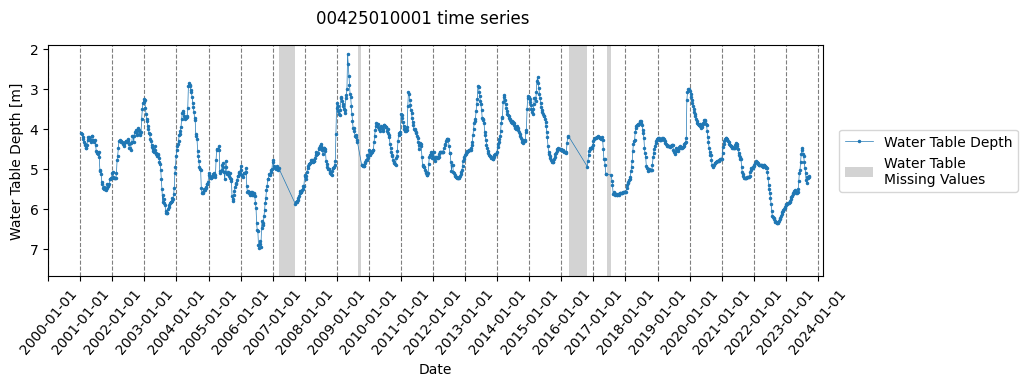

In [23]:
plot_ts_with_gaps(y = wt_depth_all_time_series_aggregated[sensor_id_list[2]]["Value"].values,
                  date = wt_depth_all_time_series_aggregated[sensor_id_list[2]]["Date"].values,
                  title = sensor_id_list[1] + " time series", width = 10,
                  height = 3, temp_freq='W', y_lim = 0.1, linewidth = 0.5, x_legend = 1.26,
                  xlimits = [np.datetime64('2000-01-01'), np.datetime64('2024-03-01')],
                  saving_path = None)

### Meteorological data

In [24]:
# Aggregate in time computing cumulative rainfall and snowfall
meteorological_ds = meteorological_ds.resample(time=temp_freq).mean() # should be closed on the right

In [25]:
meteorological_ds

<xarray.Dataset>
Dimensions:  (lon: 8, lat: 5, time: 1786)
Coordinates:
  * lon      (lon) float64 6.938 7.063 7.188 7.313 7.438 7.563 7.688 7.813
  * lat      (lat) float64 44.31 44.44 44.56 44.69 44.81
  * time     (time) datetime64[ns] 1990-01-07 1990-01-14 ... 2024-03-24
Data variables:
    prec     (time, lat, lon) float32 0.004426 0.002858 ... 0.2148 0.1768
    tmax     (time, lat, lon) float32 270.2 274.3 275.1 ... 291.0 291.1 291.4
    tmin     (time, lat, lon) float32 265.7 267.9 269.2 ... 280.9 281.3 281.2
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Mar 19 09:42:23 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [26]:
list(meteorological_ds.keys())

['prec', 'tmax', 'tmin']

### Space-Average Total Precipitation

This is for computing the mean precipitation of each raster image and display it with the water table depth time series in the plots

In [27]:
# Averaging in speace all the pixel of the clipped raster

# Compute weekly mean to plot precipitations and water table depth jointly
# A mean over the space is computed for each week
weekly_mean_precipitations = meteorological_ds["prec"].mean(axis = (1,2)).to_dataframe();
weekly_mean_precipitations["Date"] = weekly_mean_precipitations.index
weekly_mean_precipitations.index = range(0,len(weekly_mean_precipitations.index))
#weekly_mean_precipitations = weekly_mean_precipitations.loc[(weekly_mean_precipitations["Date"]>=selected_dataset["Date"].min()) & (weekly_mean_precipitations["Date"]<=selected_dataset["Date"].max())]
weekly_mean_precipitations.reset_index(inplace = True, drop = True)
weekly_mean_precipitations

prec       Date
0      0.001065 1990-01-07
1      0.000000 1990-01-14
2      0.000000 1990-01-21
3      0.279988 1990-01-28
4      0.678878 1990-02-04
...         ...        ...
1781   1.194062 2024-02-25
1782  21.381340 2024-03-03
1783   9.854746 2024-03-10
1784   0.824634 2024-03-17
1785   0.166296 2024-03-24

[1786 rows x 2 columns]

In [ ]:
# IF ONE WANT TO COMPUTE THE MEAN OF THE ONLY 4 NEAREST NEIGHBOURING PIXEL TO THE SELECTED SENSOR

# # Averaging in speace the 4 nearest pixel to the selected sensor

# # Load the shapefile
# arpa_wt_sensors = gpd.read_file(shapefile_path + "CN_TO_observed_d_t_c_stations.shp")
# arpa_wt_sensors = arpa_wt_sensors.to_crs('epsg:4326')

# # Retrieve sensor's coordinates
# selected_sensor_long = arpa_wt_sensors["geometry"].loc[arpa_wt_sensors["ID_code"] == selected_sensor].geometry.x
# selected_sensor_lat = arpa_wt_sensors["geometry"].loc[arpa_wt_sensors["ID_code"] == selected_sensor].geometry.y
# print("Sensor's Long: ", selected_sensor_long)
# print("Sensor's Lat: ", selected_sensor_lat)

# # Define the spatial resolion [°]
# raster_resolution = 0.125

# # Clip on the point taking the 4 nearest pixel to the sensor
# meteo_features_4neighbors = meteo_features.rio.clip_box( minx = selected_sensor_long-(raster_resolution/2), maxx= selected_sensor_long+(raster_resolution/2),
#                                      miny= selected_sensor_lat-(raster_resolution/2), maxy= selected_sensor_lat+(raster_resolution/2))


# # Compute the weekly averange and define the dataframe
# weekly_mean_precipitations_4neighbors = meteo_features_4neighbors["prec"].mean(axis = (1,2)).drop("spatial_ref").to_dataframe();
# weekly_mean_precipitations_4neighbors["Date"] = weekly_mean_precipitations_4neighbors.index
# weekly_mean_precipitations_4neighbors.index = range(0,1768)
# weekly_mean_precipitations_4neighbors = weekly_mean_precipitations_4neighbors.loc[(weekly_mean_precipitations_4neighbors["Date"]>=selected_dataset["Date"].min()) & (weekly_mean_precipitations_4neighbors["Date"]<=selected_dataset["Date"].max())]
# weekly_mean_precipitations_4neighbors.reset_index(inplace = True, drop = True)
# weekly_mean_precipitations_4neighbors

In [ ]:
# plt.figure(figsize = (10,5))
# plt.plot(weekly_mean_precipitations_4neighbors["prec"], color = "tab:red")
# plt.plot(weekly_mean_precipitations["prec"], color = "tab:blue")
# plt.show()

In [ ]:
# plt.figure(figsize = (10,5))
# plt.plot(weekly_mean_precipitations["prec"], color = "tab:blue")
# plt.plot(weekly_mean_precipitations_4neighbors["prec"], color = "tab:red")
# plt.show()

### Checks and analysis

In [29]:
# Check aggregation computations

for variable in list(meteorological_ds.keys()):
  check = []
  for i in range(0,len(meteorological_ds.time)):
    check_obs = i
    cum_days = meteorological_ds[variable].loc[meteorological_ds.time.values[check_obs]- np.timedelta64(6, "D"): meteorological_ds.time.values[check_obs]].mean(axis  = 0)
    check.append(np.equal(cum_days.values, meteorological_ds[variable][check_obs].values).all())
  if all(check):
    print(str(variable) + " OK")
  else:
    print(str(variable) + " some aggregation does not match!")

prec OK
tmax OK
tmin OK


#### Min Max Dates


In [28]:
# Disply max dates
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i] + " max date: " + str(wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Date"].max()))

Savigliano 00421510001 max date: 2023-12-31 00:00:00
Vottignasco 00425010001 max date: 2023-12-31 00:00:00
Racconigi 00417910001 max date: 2023-09-24 00:00:00


In [ ]:
# Disply min dates
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i] + " max date: " + str(wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Date"].min()))

Savigliano 00421510001 max date: 2001-02-25 00:00:00
Vottignasco 00425010001 max date: 2001-07-15 00:00:00
Racconigi 00417910001 max date: 2001-01-14 00:00:00


#### Consistency of time period

In [43]:
# With Brussolo et al. (2022) meteorological data a subset was necessary. Now, with
# ARPA meteorological data this is only a check: meteorological data are available for
# the same period in which we have water table depth measurements?


# In particular, each time series in the dictionary has to be costrained to have:
# 1) a minimum date bigger than the minimum date of meteo data
# 2) a maximum date bigger than one time step (temp_freq) than the maximum of meteo data
# This is becasue meteo data up to t-1 are used to predict water table at time t or a sequence from t to t+m

past_meteo_images = 104 # 24 weeks i.e. 6 months

# min limit
for i in range(0,len(sensor_id_list)):
  wt_depth_all_time_series_aggregated[sensor_id_list[i]] = wt_depth_all_time_series_aggregated[sensor_id_list[i]].loc[wt_depth_all_time_series_aggregated[sensor_id_list[i]].Date > (meteorological_ds.time.min().values + np.timedelta64(past_meteo_images, temp_freq) ),:]

# max limit
for i in range(0,len(sensor_id_list)):
  wt_depth_all_time_series_aggregated[sensor_id_list[i]] = wt_depth_all_time_series_aggregated[sensor_id_list[i]].loc[wt_depth_all_time_series_aggregated[sensor_id_list[i]].Date <= (meteorological_ds.time.max().values + np.timedelta64(1, temp_freq) ),:]

In [44]:
# Consistency check
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i] + " max date: " + str(wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Date"].max()))

Savigliano 00421510001 max date: 2023-12-31 00:00:00
Vottignasco 00425010001 max date: 2023-12-31 00:00:00
Racconigi 00417910001 max date: 2023-09-24 00:00:00


In [46]:
# Consistency check
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i] + " min date: " + str(wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Date"].min()))

Savigliano 00421510001 min date: 2001-02-25 00:00:00
Vottignasco 00425010001 min date: 2001-07-15 00:00:00
Racconigi 00417910001 min date: 2001-01-14 00:00:00


In [45]:
# Total observations
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i] + " total observations: " + str(len(wt_depth_all_time_series_aggregated[sensor_id_list[i]])))

Savigliano 00421510001 total observations: 938
Vottignasco 00425010001 total observations: 879
Racconigi 00417910001 total observations: 1116


#### Look for common dates

In [ ]:
common_dates = wt_depth_all_time_series_aggregated[sensor_id_list[0]]["Date"]
for i in range(1,len(sensor_id_list)):
  common_dates = common_dates[common_dates.isin(wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Date"])]

In [ ]:
common_dates

20    2001-07-15
21    2001-07-22
22    2001-07-29
23    2001-08-05
24    2001-08-12
         ...    
919   2023-08-27
920   2023-09-03
921   2023-09-10
922   2023-09-17
923   2023-09-24
Name: Date, Length: 748, dtype: datetime64[ns]

##### Subset for common dates

In [ ]:
wt_depth_all_time_series_aggregated_commond_dates = copy.deepcopy(wt_depth_all_time_series_aggregated)

In [ ]:
for i in range(0,len(sensor_id_list)):
  wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[i]] = wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[i]][wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[i]]["Date"].isin(common_dates)]
  wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[i]] = wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[i]].reset_index(drop = False)

In [ ]:
wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[0]]

index       Date      ID_code     Value
0       20 2001-07-15  00421510001  3.691071
1       21 2001-07-22  00421510001  3.745000
2       22 2001-07-29  00421510001  3.787857
3       23 2001-08-05  00421510001  3.834643
4       24 2001-08-12  00421510001  3.849643
..     ...        ...          ...       ...
743    919 2023-08-27  00421510001  4.163333
744    920 2023-09-03  00421510001  4.033810
745    921 2023-09-10  00421510001  4.067619
746    922 2023-09-17  00421510001  4.075238
747    923 2023-09-24  00421510001  4.050952

[748 rows x 4 columns]

## Autocorrelation

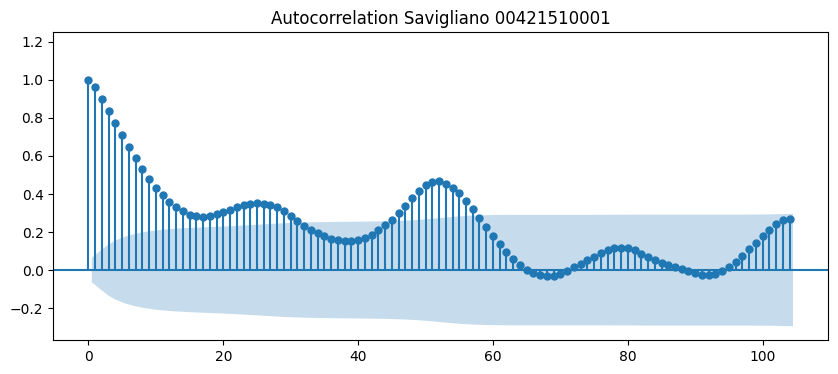

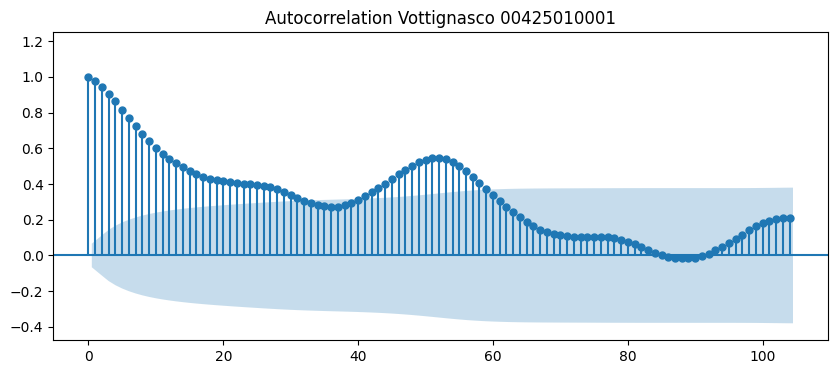

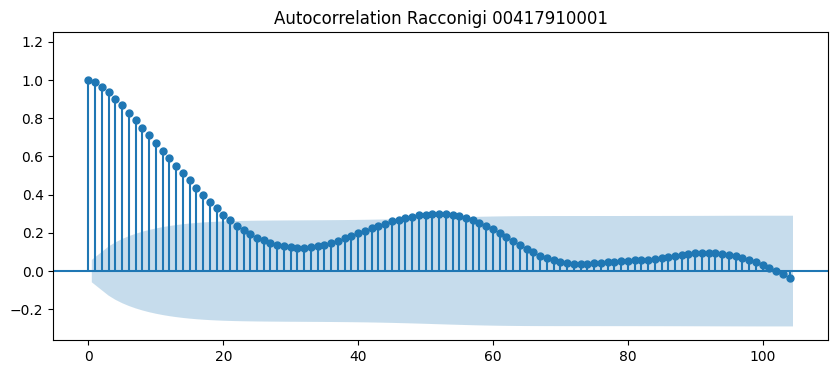

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# plot the auto correlation
sns.mpl.rc("figure", figsize=(10, 4))
for i in range(len(sensor_id_list)):
  plot_acf(wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Value"].values, lags = 104, title = f"Autocorrelation {sensor_municipalities_id_codes[i]}", auto_ylims = True, adjusted = True)

## Plots

In [ ]:
# Define names for png files

time_series_saving_names_png = [water_table_time_series_path_file_names[i].replace("", "")[:-4] + "_weekly_ARPA.png" for i in range(0,len(sensor_titles))]

time_series_saving_names_png_with_precipitation = [time_series_saving_names_png[i].replace("_weekly_ARPA.png", "_and_Precipitations") + "_weekly_ARPA.png" for i in range(0,len(sensor_titles))]


In [ ]:
time_series_saving_names_png[0]

'Savigliano_00421510001_Water_Table_Depth_Grana_Maira_weekly_ARPA.png'

In [ ]:
time_series_saving_names_png_with_precipitation[0]

'Savigliano_00421510001_Water_Table_Depth_Grana_Maira_and_Precipitations_weekly_ARPA.png'

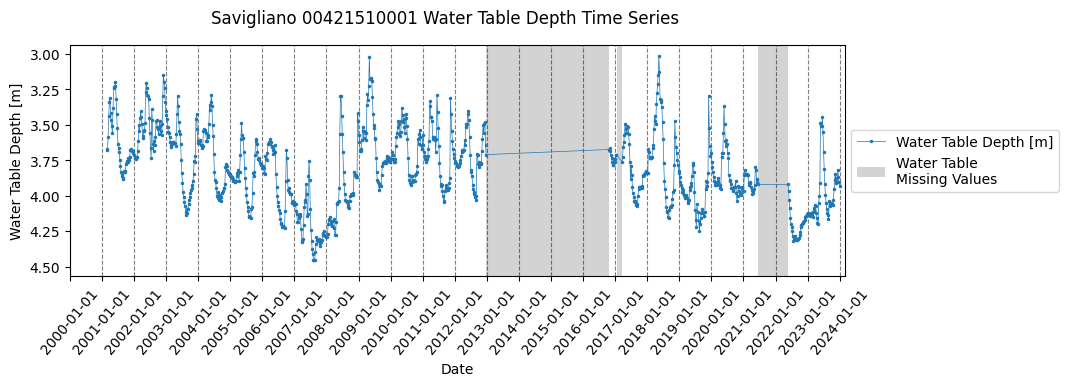

In [31]:
look_at_sensor = 0
plot_ts_with_gaps(date = wt_depth_all_time_series_aggregated[sensor_id_list[look_at_sensor]]["Date"].values,
                  y = wt_depth_all_time_series_aggregated[sensor_id_list[look_at_sensor]]["Value"].values,
                  title = sensor_titles[look_at_sensor] + " Time Series",
                  width = 10,
                  height = 3, temp_freq='W', y_lim = 0.025, linewidth = 0.5, x_legend = 1.285,
                  label_base_series = "Water Table Depth [m]", color_base_series = "tab:blue",
                  xlimits = [np.datetime64("2000-01-01"), np.datetime64("2024-03-01")],
                  zoom = None,
                  saving_path = None)

# saving_path: plot_path + time_series_saving_names_png[look_at_sensor]

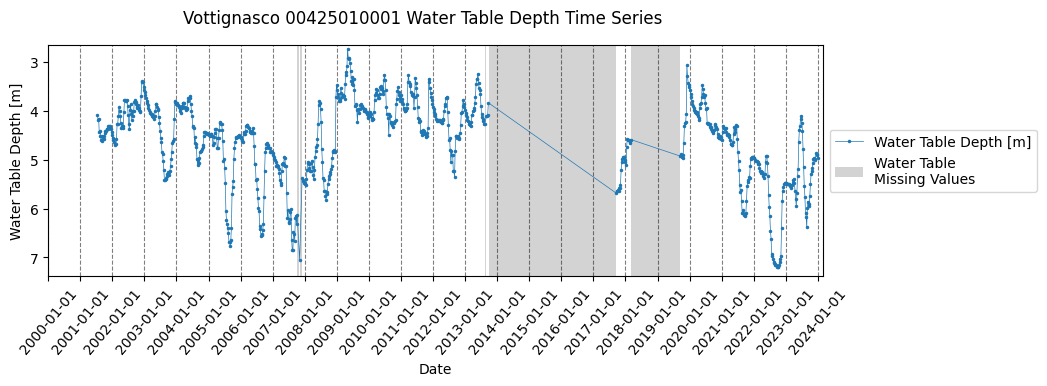

In [ ]:
look_at_sensor = 1
plot_ts_with_gaps(date = wt_depth_all_time_series_aggregated[sensor_id_list[look_at_sensor]]["Date"].values,
                  y = wt_depth_all_time_series_aggregated[sensor_id_list[look_at_sensor]]["Value"].values,
                  title = sensor_titles[look_at_sensor] + " Time Series",
                  width = 10,
                  height = 3, temp_freq='W', y_lim = 0.025, linewidth = 0.5, x_legend = 1.285,
                  label_base_series = "Water Table Depth [m]", color_base_series = "tab:blue",
                  xlimits = [np.datetime64("2000-01-01"), np.datetime64("2024-03-01")],
                  zoom = None,
                  saving_path = None)

# saving_path: plot_path + time_series_saving_names_png[look_at_sensor]

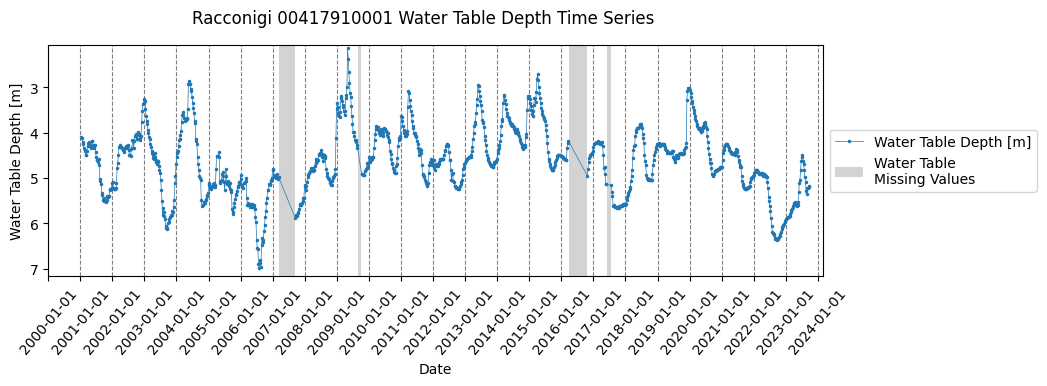

In [ ]:
look_at_sensor = 2
plot_ts_with_gaps(date = wt_depth_all_time_series_aggregated[sensor_id_list[look_at_sensor]]["Date"].values,
                  y = wt_depth_all_time_series_aggregated[sensor_id_list[look_at_sensor]]["Value"].values,
                  title = sensor_titles[look_at_sensor] + " Time Series",
                  width = 10,
                  height = 3, temp_freq='W', y_lim = 0.025, linewidth = 0.5, x_legend = 1.285,
                  label_base_series = "Water Table Depth [m]", color_base_series = "tab:blue",
                  xlimits = [np.datetime64("2000-01-01"), np.datetime64("2024-03-01")],
                  zoom = None,
                  saving_path = None)

# saving_path: plot_path + time_series_saving_names_png[look_at_sensor]

#### Saving

In [ ]:
# # Only water table
# for i in range(len(sensor_id_list)):
#   plot_ts_with_gaps(date = wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Date"].values,
#                   y = wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Value"].values,
#                   title = sensor_titles[i] + " Time Series",
#                   width = 10,
#                   height = 3, temp_freq='W', y_lim = 0.025, linewidth = 0.5, x_legend = 1.285,
#                   label_base_series = "Water Table Depth [m]", color_base_series = "tab:blue",
#                   xlimits = [np.datetime64("2000-10-01"), np.datetime64("2024-03-01")],
#                   zoom = None,
#                   saving_path = plot_path + time_series_saving_names_png[i])


In [ ]:
# # Water table with Precipitation
# for i in range(len(sensor_id_list)):
#   plot_ts_with_gaps(date = wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Date"].values,
#                   y = wt_depth_all_time_series_aggregated[sensor_id_list[i]]["Value"].values,
#                   title = sensor_titles[i] + "and Precipitations Time Series ",
#                   width = 10,
#                   height = 3, temp_freq='W', y_lim = 0.025, linewidth = 0.5, x_legend = 1.295,
#                   label_base_series = "Water Table Depth [m]", color_base_series = "tab:blue",
#                   xlimits = [np.datetime64("2000-10-01"), np.datetime64("2024-03-01")],
#                   zoom = None,
#                   precipitations = weekly_mean_precipitations["prec"].values,
#                   date_precipitations = weekly_mean_precipitations["Date"].values,
#                   saving_path = plot_path + time_series_saving_names_png_with_precipitation[i])


### Common dates plots

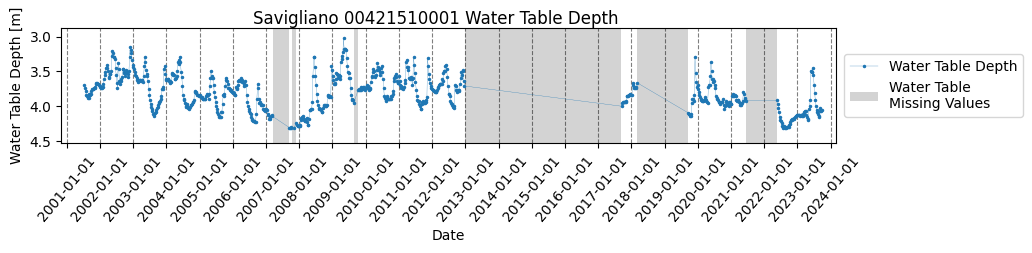

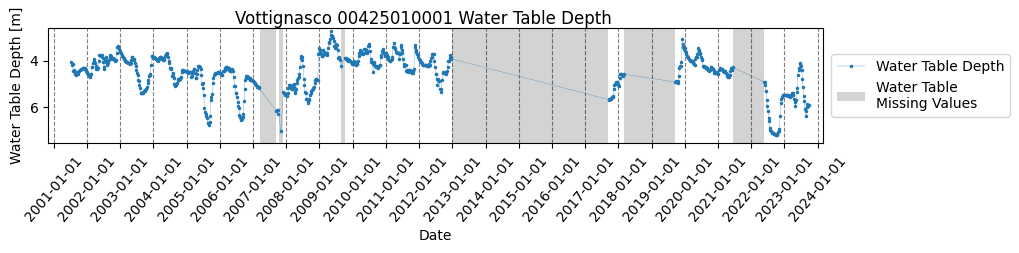

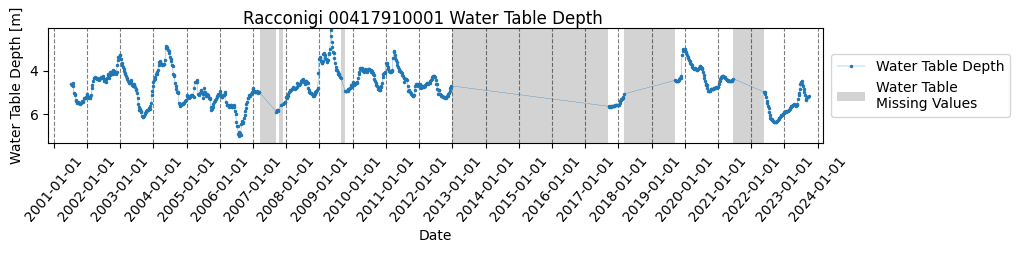

In [ ]:
for i in range(len(sensor_id_list)):

      plot_ts_with_gaps(y = wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[i]]["Value"].values,
                        date = wt_depth_all_time_series_aggregated_commond_dates[sensor_id_list[i]]["Date"].values,
                        title = sensor_titles[i],
                        width = 10, height = 1.5,
                        temp_freq='W', y_lim = 0.05,
                        x_legend = 1.25)

# Training-Validation-Test splits

## Target variable

In [32]:
training_target_ds_dictionary_unique_pairs = dict()
validation_target_ds_dictionary_unique_pairs = dict()
test_target_ds_dictionary_unique_pairs = dict()
all_sets_target_ds_dictionary_unique_pairs = dict()

training_target_ds_dictionary = dict()
validation_target_ds_dictionary = dict()
test_target_ds_dictionary = dict()

training_target_numpy_values_dictionary = dict()
validation_target_numpy_values_dictionary = dict()
test_target_numpy_values_dictionary = dict()

training_target_numpy_dates_dictionary = dict()
validation_target_numpy_dates_dictionary = dict()
test_target_numpy_dates_dictionary = dict()

# number of past meteo images for each input. Used to make splitted dataset truly independet
# inserted through the parameter "split_margin" in the following function
past_meteo_images = 104
step_ahead = 0 # >1 for a seq2seq (many-to-many) scenario
temp_freq = "W"
target_name = "Value"
date_name = "Date"
training_upto_date = np.datetime64('2016-01-01')
test_from_date = np.datetime64('2022-01-01')

for i in range(len(sensor_id_list)):

  # Initialization
  target_name_list = [target_name]
  date_name_list = [date_name]

  # define the splits for each sensor time series
  training_target_ds_dictionary_unique_pairs[sensor_id_list[i]], validation_target_ds_dictionary_unique_pairs[sensor_id_list[i]], test_target_ds_dictionary_unique_pairs[sensor_id_list[i]] = train_test_split_ds(ds = wt_depth_all_time_series_aggregated[sensor_id_list[i]],
                                                                    training_perc = None,
                                                                    only_last_as_test= False,
                                                                    training_upto_date = training_upto_date,
                                                                    test_from_date = test_from_date,
                                                                    date_name = "Date", temp_freq = temp_freq,
                                                                    valid_perc = None, step_ahead = step_ahead, delays = 0,
                                                                    count_time = True, split_margin = past_meteo_images,
                                                                    retrive_limits_info = False)

  # Needed for plot - given the gaps between sets it differs from the original time series
  all_sets_target_ds_dictionary_unique_pairs[sensor_id_list[i]] = pd.concat([training_target_ds_dictionary_unique_pairs[sensor_id_list[i]],
                                                                        validation_target_ds_dictionary_unique_pairs[sensor_id_list[i]],
                                                                        test_target_ds_dictionary_unique_pairs[sensor_id_list[i]]]).sort_index()


  #####################
  # For seq2seq models
  # Here the output sequences are created shifting the datasets
  #####################
  if (step_ahead>0):
  # In case of seq2seq the sliding window has to be constructed
  # "unique_pairs" ds is shifted and each row will contain an output sequence

      # Add missing date and fill them with NA - useful for building sliding windows without missing values
      # bacuse later every sequence with some missing values will be eliminated
      training_target_ds_dictionary[sensor_id_list[i]] = insert_missing_dates(training_target_ds_dictionary_unique_pairs[sensor_id_list[i]], "Date", temp_freq)
      validation_target_ds_dictionary[sensor_id_list[i]] = insert_missing_dates(validation_target_ds_dictionary_unique_pairs[sensor_id_list[i]], "Date", temp_freq)
      test_target_ds_dictionary[sensor_id_list[i]] = insert_missing_dates(test_target_ds_dictionary_unique_pairs[sensor_id_list[i]], "Date", temp_freq)

      # Now retrieve the name of the news shifted columns in the list "variable_names_ahead"
      # and compute the ahead shifted dataset for the seq2seq model
      # Also "Date" for retrieving date for each target observation - needed for plotting predicted sequences

      variable_to_shift = target_name_list + date_name_list #+  month_dummies_names # ["Value", "Date"]

      training_target_ds_dictionary[sensor_id_list[i]], variable_names_ahead = delayed_ds(ds = training_target_ds_dictionary[sensor_id_list[i]], variable_to_shift = variable_to_shift,
                                            shift_sequence = np.flip(np.arange(-step_ahead,0)), na_fill = False,
                                            time_ordering = True)

      validation_target_ds_dictionary[sensor_id_list[i]], __ = delayed_ds(ds = validation_target_ds_dictionary[sensor_id_list[i]], variable_to_shift = variable_to_shift,
                                            shift_sequence = np.flip(np.arange(-step_ahead,0)), na_fill = False,
                                            time_ordering = True) # variable_names_ahead the same as for the training!

      test_target_ds_dictionary[sensor_id_list[i]], __ = delayed_ds(ds = test_target_ds_dictionary[sensor_id_list[i]], variable_to_shift = variable_to_shift,
                                            shift_sequence = np.flip(np.arange(-step_ahead,0)), na_fill = False,
                                            time_ordering = True) # variable_names_ahead the same as for the training!


      # extract value column names and date column names
      target_names_ahead = find_value_from_queries_among_keys(["Value"], variable_names_ahead)
      date_names_ahead = find_value_from_queries_among_keys(["Date"], variable_names_ahead)
      # month_dummies_names_ahead = find_value_from_queries_among_keys(month_dummies_names, variable_names_ahead)

      # Append the non shifted (original) column name and create a list - useful for extract the numpy object after:
      # all the step ahead and the current value are the target
      # all the step ahead and the current dates are needed for plotting the predicted values

      target_name_list = ["Value"]
      target_name_list.extend(target_names_ahead)
      date_name_list = ["Date"]
      date_name_list.extend(date_names_ahead)
      # month_dummies_names_list = month_dummies_names
      # month_dummies_names.extend(month_dummies_names_ahead)

      # In case of delayed features compute here: ...

      # Discard input or output sequence with missing values

      training_target_ds_dictionary[sensor_id_list[i]] = training_target_ds_dictionary[sensor_id_list[i]].dropna()
      validation_target_ds_dictionary[sensor_id_list[i]] = validation_target_ds_dictionary[sensor_id_list[i]].dropna()
      test_target_ds_dictionary[sensor_id_list[i]] = test_target_ds_dictionary[sensor_id_list[i]].dropna()

      training_target_ds_dictionary[sensor_id_list[i]] = training_target_ds_dictionary[sensor_id_list[i]].reset_index(drop=True)
      validation_target_ds_dictionary[sensor_id_list[i]] = validation_target_ds_dictionary[sensor_id_list[i]].reset_index(drop=True)
      test_target_ds_dictionary[sensor_id_list[i]] = test_target_ds_dictionary[sensor_id_list[i]].reset_index(drop=True)

  else:
      # In case of seq2vale the "unique_pairs" ds equals the output object
      training_target_ds_dictionary[sensor_id_list[i]] = training_target_ds_dictionary_unique_pairs[sensor_id_list[i]]
      validation_target_ds_dictionary[sensor_id_list[i]] = validation_target_ds_dictionary_unique_pairs[sensor_id_list[i]]
      test_target_ds_dictionary[sensor_id_list[i]] = test_target_ds_dictionary_unique_pairs[sensor_id_list[i]]

  #####################

  #####################

  # Extract numpy array for training, validation, test, and dates
  # These numpy array will be the actual input/output of the models

  training_target_numpy_values_dictionary[sensor_id_list[i]] = filter_ds_by_coulmn(training_target_ds_dictionary[sensor_id_list[i]],
                                                                            selected_columns = target_name_list,
                                                                            numpy_out = True)
  training_target_numpy_dates_dictionary[sensor_id_list[i]] = filter_ds_by_coulmn(training_target_ds_dictionary[sensor_id_list[i]],
                                                                            selected_columns = date_name_list,
                                                                            numpy_out = True)
                                                                            # np.array of dimension (train length, ste_ahead)

  validation_target_numpy_values_dictionary[sensor_id_list[i]] = filter_ds_by_coulmn(validation_target_ds_dictionary[sensor_id_list[i]],
                                                                                     selected_columns = target_name_list,
                                                                                     numpy_out = True)

  validation_target_numpy_dates_dictionary[sensor_id_list[i]] = filter_ds_by_coulmn(validation_target_ds_dictionary[sensor_id_list[i]],
                                                                                    selected_columns = date_name_list,
                                                                                    numpy_out = True)
                                                                             # np.array of dimension (train length, ste_ahead)

  test_target_numpy_values_dictionary[sensor_id_list[i]] = filter_ds_by_coulmn(test_target_ds_dictionary[sensor_id_list[i]],
                                                                               selected_columns = target_name_list,
                                                                               numpy_out = True)
  test_target_numpy_dates_dictionary[sensor_id_list[i]] = filter_ds_by_coulmn(test_target_ds_dictionary[sensor_id_list[i]],
                                                                              selected_columns = date_name_list,
                                                                              numpy_out = True)
                                                                            # np.array of dimension (test length, ste_ahead)


### Infos

In [33]:
# Acutal total observations
# Cause of data elimination: gap between sets and sequence completeness for the seq2seq case
actual_total_observation = dict()
for i in range(0,len(sensor_id_list)):
  actual_total_observation[sensor_id_list[i]] = training_target_numpy_values_dictionary[sensor_id_list[i]].shape[0] + validation_target_numpy_values_dictionary[sensor_id_list[i]].shape[0] + test_target_numpy_values_dictionary[sensor_id_list[i]].shape[0]


In [34]:
print("Training set shapes and percentages: ")
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i], training_target_numpy_values_dictionary[sensor_id_list[i]].shape, sep=" ", end = " - ")
  print("Percentage: ", str(round(training_target_numpy_values_dictionary[sensor_id_list[i]].shape[0]/actual_total_observation[sensor_id_list[i]], 3)*100),"%", end = " - ")
  print("First Date: ", str(training_target_numpy_dates_dictionary[sensor_id_list[i]][0].astype('datetime64[D]')), end = " - ")
  print("Last Date: ", str(training_target_numpy_dates_dictionary[sensor_id_list[i]][-1].astype('datetime64[D]')))

Training set shapes and percentages: 
Savigliano 00421510001 (618, 1) - Percentage:  70.1 % - First Date:  ['2001-02-25'] - Last Date:  ['2012-12-23']
Vottignasco 00425010001 (629, 1) - Percentage:  81.2 % - First Date:  ['2001-07-15'] - Last Date:  ['2013-09-22']
Racconigi 00417910001 (749, 1) - Percentage:  79.3 % - First Date:  ['2001-01-14'] - Last Date:  ['2015-12-27']


In [ ]:
print("Validation set shapes and percentages: ")
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i], validation_target_numpy_values_dictionary[sensor_id_list[i]].shape, sep=" ", end = " - ")
  print("Percentage: ", str(round(validation_target_numpy_values_dictionary[sensor_id_list[i]].shape[0]/actual_total_observation[sensor_id_list[i]], 3)*100),"%", end = " - ")
  print("First Date: ", str(validation_target_numpy_dates_dictionary[sensor_id_list[i]][0].astype('datetime64[D]')), end = " - ")
  print("Last Date: ", str(validation_target_numpy_dates_dictionary[sensor_id_list[i]][-1].astype('datetime64[D]')))

Validation set shapes and percentages: 
Savigliano 00421510001 (179, 1) - Percentage:  20.3 % - First Date:  ['2016-10-23'] - Last Date:  ['2020-05-17']
Vottignasco 00425010001 (41, 1) - Percentage:  5.3 % - First Date:  ['2017-09-17'] - Last Date:  ['2019-12-29']
Racconigi 00417910001 (105, 1) - Percentage:  11.1 % - First Date:  ['2017-12-31'] - Last Date:  ['2019-12-29']


In [ ]:
print("Test set shapes and percentages: ")
for i in range(0,len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i], test_target_numpy_values_dictionary[sensor_id_list[i]].shape, sep=" ", end = " - ")
  print("Percentage: ", str(round(test_target_numpy_values_dictionary[sensor_id_list[i]].shape[0]/actual_total_observation[sensor_id_list[i]], 3)*100),"%", end = " - ")
  print("First Date: ", str(test_target_numpy_dates_dictionary[sensor_id_list[i]][0].astype('datetime64[D]')), end = " - ")
  print("Last Date: ", str(test_target_numpy_dates_dictionary[sensor_id_list[i]][-1].astype('datetime64[D]')))

Test set shapes and percentages: 
Savigliano 00421510001 (85, 1) - Percentage:  9.6 % - First Date:  ['2022-05-22'] - Last Date:  ['2023-12-31']
Vottignasco 00425010001 (105, 1) - Percentage:  13.5 % - First Date:  ['2022-01-02'] - Last Date:  ['2023-12-31']
Racconigi 00417910001 (91, 1) - Percentage:  9.6 % - First Date:  ['2022-01-02'] - Last Date:  ['2023-09-24']


### Plots

#### Inspection

In [35]:
# Select a sensor
selected_sensor_number = 2


In [36]:
training_target_ds_dictionary[sensor_id_list[selected_sensor_number]]

Date      ID_code     Value
0   2001-01-14  00417910001  4.100952
1   2001-01-21  00417910001  4.127381
2   2001-01-28  00417910001  4.195714
3   2001-02-04  00417910001  4.258333
4   2001-02-11  00417910001  4.336667
..         ...          ...       ...
744 2015-11-29  00417910001  4.490000
745 2015-12-06  00417910001  4.496667
746 2015-12-13  00417910001  4.499524
747 2015-12-20  00417910001  4.500952
748 2015-12-27  00417910001  4.510952

[749 rows x 3 columns]

In [ ]:
training_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][1,:]

array(['2001-01-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
training_target_numpy_values_dictionary[sensor_id_list[selected_sensor_number]][1,:]

array([4.12738095])

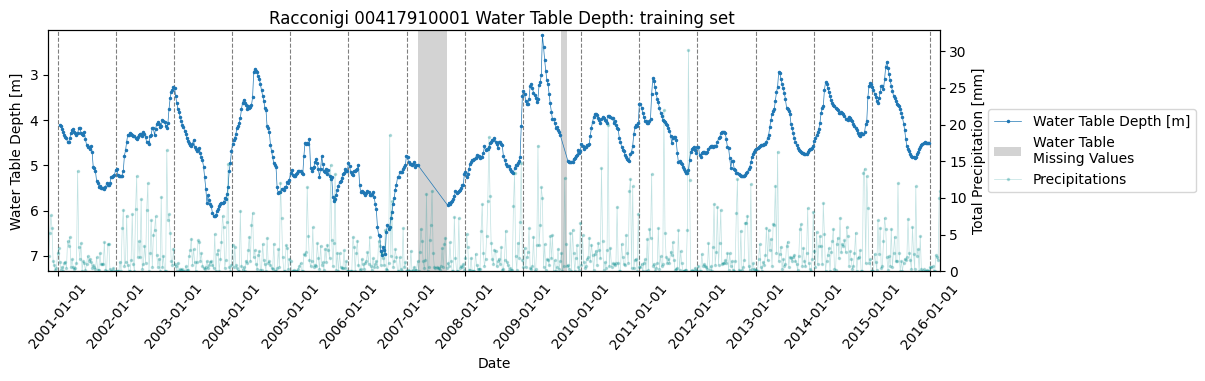

In [37]:
plot_ts_with_gaps(y = training_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = training_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_titles[selected_sensor_number] + ": training set", width = 10,
                  height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.295,
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

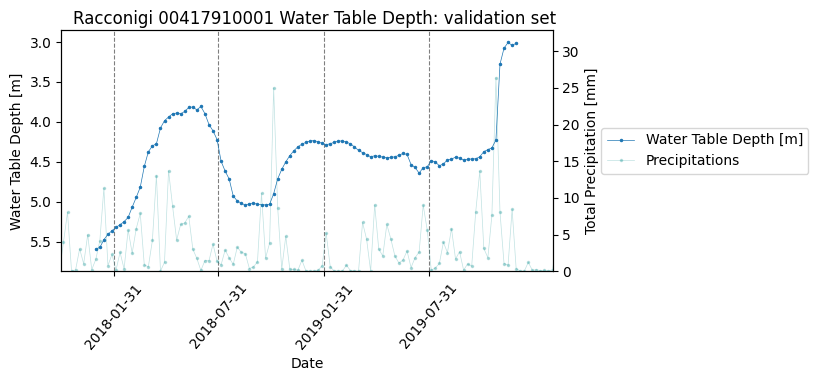

In [38]:
plot_ts_with_gaps(y = validation_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = validation_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_titles[selected_sensor_number] + ": validation set", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05,
                  linewidth = 0.5, x_legend = 1.535, xticks_freq = "6M",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations=weekly_mean_precipitations["Date"].values)

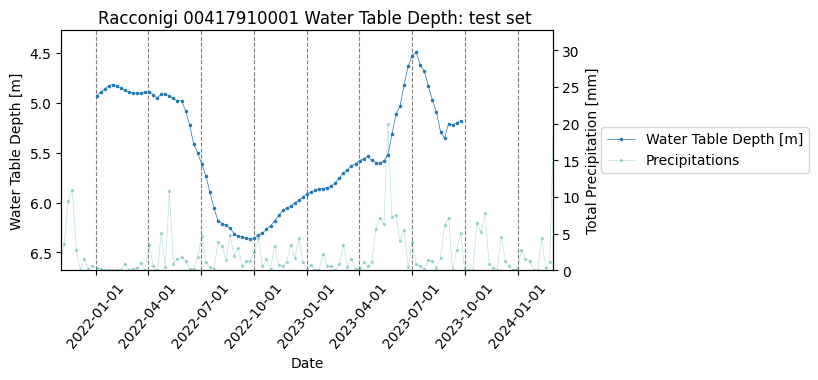

In [39]:
plot_ts_with_gaps(y = test_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = test_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_titles[selected_sensor_number] + ": test set", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05,
                  linewidth = 0.5, x_legend = 1.535, xticks_freq = "QS",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

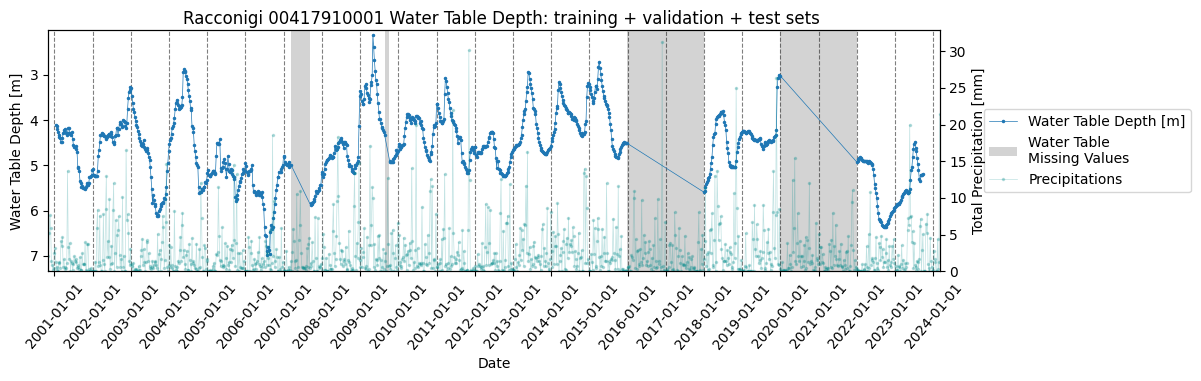

In [40]:
plot_ts_with_gaps(y = all_sets_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = all_sets_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
                  title = sensor_titles[selected_sensor_number] + ": training + validation + test sets",
                  label_base_series = "Water Table Depth [m]",
                  width = 10, height = 3, temp_freq='W',
                  y_lim = 0.05, linewidth = 0.5, x_legend = 1.29,
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

#### Saving

In [ ]:
# Plot sets file names
plot_training_file_names = ["target_water_table_depth/training_set_" + sensor_municipalities_id_codes[i] for i in range(len(sensor_municipalities_id_codes))]
plot_training_file_names = [plot_training_file_names[i].replace(" ", "_") for i in range(len(sensor_municipalities_id_codes))]
plot_training_file_names = [plot_training_file_names[i] + ".png" for i in range(len(sensor_municipalities_id_codes))]
plot_training_file_names

plot_validation_file_names = ["target_water_table_depth/validation_set_" + sensor_municipalities_id_codes[i] for i in range(len(sensor_municipalities_id_codes))]
plot_validation_file_names = [plot_validation_file_names[i].replace(" ", "_") for i in range(len(sensor_municipalities_id_codes))]
plot_validation_file_names = [plot_validation_file_names[i] + ".png" for i in range(len(sensor_municipalities_id_codes))]
plot_validation_file_names

plot_test_file_names = ["target_water_table_depth/test_set_" + sensor_municipalities_id_codes[i] for i in range(len(sensor_municipalities_id_codes))]
plot_test_file_names = [plot_test_file_names[i].replace(" ", "_") for i in range(len(sensor_municipalities_id_codes))]
plot_test_file_names = [plot_test_file_names[i] + ".png" for i in range(len(sensor_municipalities_id_codes))]
plot_test_file_names

['target_water_table_depth/test_set_Savigliano_00421510001.png',
 'target_water_table_depth/test_set_Vottignasco_00425010001.png',
 'target_water_table_depth/test_set_Racconigi_00417910001.png']

In [ ]:
# Loop previous plot and save them

# for selected_sensor_number in range(0,len(sensor_id_list)):

#   plot_ts_with_gaps(y = training_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
#                   date = training_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
#                   label_base_series = "Water Table Depth [m]",
#                   title = sensor_titles[selected_sensor_number] + ": training set", width = 10,
#                   height = 3, temp_freq='W', y_lim = 0.05, linewidth = 0.5, x_legend = 1.285,
#                   saving_path = saving_split_path + plot_training_file_names[selected_sensor_number])

#   plot_ts_with_gaps(y = validation_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
#                   date = validation_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
#                   label_base_series = "Water Table Depth [m]",
#                   title = sensor_titles[selected_sensor_number] + ": validation set", width = 6,
#                   height = 3, temp_freq='W', y_lim = 0.05,
#                   linewidth = 0.5, x_legend = 1.475, xticks_freq = "6M",
#                   saving_path = saving_split_path + plot_validation_file_names[selected_sensor_number])

#   plot_ts_with_gaps(y = test_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
#                   date = test_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
#                   label_base_series = "Water Table Depth [m]",
#                   title = sensor_titles[selected_sensor_number] + ": test set", width = 6,
#                   height = 3, temp_freq='W', y_lim = 0.05,
#                   linewidth = 0.5, x_legend = 1.475, xticks_freq = "QS",
#                   saving_path = saving_split_path + plot_test_file_names[selected_sensor_number])



## Meteorological data (Feature)

For each value or sequence of water table to be predicted, a sequence of `past_meteo_images` (specify the number) meteo images in the past is used as input. Expert said to use 6 months of previous meteorological information, i.e. 24 weeks

In [41]:
encoder = OneHotEncoder(categories = [np.arange(1,13).astype("str")],
                        drop = ['12'], sparse_output=False)
encoder.fit([[np.arange(1,13).astype("str")[i]] for i in range(0,12)])
# encoder.get_feature_names_out(["Month"])

OneHotEncoder(categories=[array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype='<U21')],
              drop=['12'], sparse_output=False)

In [49]:
training_meteo_features_dictionary = dict()
validation_meteo_features_dictionary = dict()
test_meteo_features_dictionary = dict()

for i in range(0,len(sensor_id_list)):

  # Create a list with 3 elements:
  # 1) A numpy-array (samples, past_meteo_images, height, width, variables) with the image time series for each sample
  # 2) A list with "samples" element, each element contains the dates of each image in the image time series of the corresponding sample
  # 3) A numpy-array (samles, past_meteo_images, 11) contains the one hot encoding of the months in each image time series

  # channel = "variable" to create the first object with variables in the last dimension (channel dimension)
  print(sensor_municipalities_id_codes[i])
  print("Training")
  training_meteo_features_dictionary[sensor_id_list[i]] = create_x_meteo_obj(meteorological_ds,
                                     training_target_numpy_dates_dictionary[sensor_id_list[i]][:,0],
                                     time_coord = "time", numb_past_images = past_meteo_images,
                                     temp_freq = 'W', channel = "variables",
                                     month_OneHotEnc= True,
                                     encoder = encoder)
  print("Validation")
  # Print: percentage of the process and shape of the array for the i-th sample (Observation)
  # for the first element of the list

  # Create the same object described before for the validation set
  validation_meteo_features_dictionary[sensor_id_list[i]] = create_x_meteo_obj(meteorological_ds,
                                     validation_target_numpy_dates_dictionary[sensor_id_list[i]][:,0],
                                     time_coord = "time", numb_past_images = past_meteo_images,
                                     temp_freq = 'W', channel = "variables",
                                     month_OneHotEnc= True,
                                     encoder = encoder)
  # Create the same object described before for the test set
  print("Test")
  test_meteo_features_dictionary[sensor_id_list[i]] = create_x_meteo_obj(meteorological_ds,
                                     test_target_numpy_dates_dictionary[sensor_id_list[i]][:,0],
                                     time_coord = "time", numb_past_images = past_meteo_images,
                                     temp_freq = 'W', channel = "variables",
                                     month_OneHotEnc= True,
                                     encoder = encoder)
  print("")


Savigliano 00421510001
Training
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 618
Validation
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 179
Test
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 85

Vottignasco 00425010001
Training
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 629
Validation
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 41
Test
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 105

Racconigi 00417910001
Training
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 749
Validation
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 105
Test
100.0 %. Image in [0] position with shape: (104, 5, 8, 3) - Total processed observations: 91



In [50]:
# Buil xarray objects useful for plots and normalization
# These xarrays contain unique date-value pairs
training_meteo_features_dictionary_unique_pairs = {sensor_id_list[i]: copy.deepcopy(meteorological_ds) for i in range(0,len(sensor_id_list))}
validation_meteo_features_dictionary_unique_pairs = {sensor_id_list[i]: copy.deepcopy(meteorological_ds) for i in range(0,len(sensor_id_list))}
test_meteo_features_dictionary_unique_pairs = {sensor_id_list[i]: copy.deepcopy(meteorological_ds) for i in range(0,len(sensor_id_list))}

In [51]:
for i in range(0,len(sensor_id_list)):
  # training
  unique_training_dates = np.unique(np.array(training_meteo_features_dictionary[sensor_id_list[i]][1]).flatten()) # retrieve unique dates from all input image sequences
  training_meteo_features_dictionary_unique_pairs[sensor_id_list[i]] = training_meteo_features_dictionary_unique_pairs[sensor_id_list[i]].where(training_meteo_features_dictionary_unique_pairs[sensor_id_list[i]]["time"].isin(unique_training_dates), drop=True)

  #validation
  unique_validation_dates = np.unique(np.array(validation_meteo_features_dictionary[sensor_id_list[i]][1]).flatten())
  validation_meteo_features_dictionary_unique_pairs[sensor_id_list[i]] = validation_meteo_features_dictionary_unique_pairs[sensor_id_list[i]].where(validation_meteo_features_dictionary_unique_pairs[sensor_id_list[i]]["time"].isin(unique_validation_dates), drop=True)

  #test
  unique_test_dates = np.unique(np.array(test_meteo_features_dictionary[sensor_id_list[i]][1]).flatten())
  test_meteo_features_dictionary_unique_pairs[sensor_id_list[i]] = test_meteo_features_dictionary_unique_pairs[sensor_id_list[i]].where(test_meteo_features_dictionary_unique_pairs[sensor_id_list[i]]["time"].isin(unique_test_dates), drop=True)

In [52]:
training_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]

<xarray.Dataset>
Dimensions:  (time: 884, lat: 5, lon: 8)
Coordinates:
  * lon      (lon) float64 6.938 7.063 7.188 7.313 7.438 7.563 7.688 7.813
  * lat      (lat) float64 44.31 44.44 44.56 44.69 44.81
  * time     (time) datetime64[ns] 1999-01-17 1999-01-24 ... 2015-12-20
Data variables:
    prec     (time, lat, lon) float32 2.979 3.021 3.586 ... 0.005144 0.004569
    tmax     (time, lat, lon) float32 270.0 273.9 274.8 ... 283.3 283.8 284.2
    tmin     (time, lat, lon) float32 267.1 268.3 269.3 ... 273.5 273.6 273.7
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Mar 19 09:42:23 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [53]:
validation_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]

<xarray.Dataset>
Dimensions:  (time: 208, lat: 5, lon: 8)
Coordinates:
  * lon      (lon) float64 6.938 7.063 7.188 7.313 7.438 7.563 7.688 7.813
  * lat      (lat) float64 44.31 44.44 44.56 44.69 44.81
  * time     (time) datetime64[ns] 2016-01-03 2016-01-10 ... 2019-12-22
Data variables:
    prec     (time, lat, lon) float32 0.96 0.7854 0.6893 ... 7.076 6.405 5.748
    tmax     (time, lat, lon) float32 274.1 278.2 278.1 ... 283.4 283.5 283.1
    tmin     (time, lat, lon) float32 270.2 271.9 271.8 ... 279.1 279.4 279.2
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Mar 19 09:42:23 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [54]:
test_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]

<xarray.Dataset>
Dimensions:  (time: 194, lat: 5, lon: 8)
Coordinates:
  * lon      (lon) float64 6.938 7.063 7.188 7.313 7.438 7.563 7.688 7.813
  * lat      (lat) float64 44.31 44.44 44.56 44.69 44.81
  * time     (time) datetime64[ns] 2020-01-05 2020-01-12 ... 2023-09-17
Data variables:
    prec     (time, lat, lon) float32 0.3496 0.09201 0.0004229 ... 2.574 3.975
    tmax     (time, lat, lon) float32 276.9 280.4 280.0 ... 298.7 298.9 298.7
    tmin     (time, lat, lon) float32 273.0 273.9 273.4 ... 289.9 289.9 289.7
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Mar 19 09:42:23 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

#### Inspection and checks

In [55]:
selected_sensor_number = 2

In [56]:
len(training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]])

3

In [57]:
len(test_meteo_features_dictionary[sensor_id_list[selected_sensor_number]])

3

In [58]:
indx_inspec = len(training_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]])-1
var = "tmax"
training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][indx_inspec]

array(['2013-12-29T00:00:00.000000000', '2014-01-05T00:00:00.000000000',
       '2014-01-12T00:00:00.000000000', '2014-01-19T00:00:00.000000000',
       '2014-01-26T00:00:00.000000000', '2014-02-02T00:00:00.000000000',
       '2014-02-09T00:00:00.000000000', '2014-02-16T00:00:00.000000000',
       '2014-02-23T00:00:00.000000000', '2014-03-02T00:00:00.000000000',
       '2014-03-09T00:00:00.000000000', '2014-03-16T00:00:00.000000000',
       '2014-03-23T00:00:00.000000000', '2014-03-30T00:00:00.000000000',
       '2014-04-06T00:00:00.000000000', '2014-04-13T00:00:00.000000000',
       '2014-04-20T00:00:00.000000000', '2014-04-27T00:00:00.000000000',
       '2014-05-04T00:00:00.000000000', '2014-05-11T00:00:00.000000000',
       '2014-05-18T00:00:00.000000000', '2014-05-25T00:00:00.000000000',
       '2014-06-01T00:00:00.000000000', '2014-06-08T00:00:00.000000000',
       '2014-06-15T00:00:00.000000000', '2014-06-22T00:00:00.000000000',
       '2014-06-29T00:00:00.000000000', '2014-07-06

In [59]:
training_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][indx_inspec,0]

numpy.datetime64('2015-12-27T00:00:00.000000000')

In [60]:
validation_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][0]

array(['2016-01-03T00:00:00.000000000', '2016-01-10T00:00:00.000000000',
       '2016-01-17T00:00:00.000000000', '2016-01-24T00:00:00.000000000',
       '2016-01-31T00:00:00.000000000', '2016-02-07T00:00:00.000000000',
       '2016-02-14T00:00:00.000000000', '2016-02-21T00:00:00.000000000',
       '2016-02-28T00:00:00.000000000', '2016-03-06T00:00:00.000000000',
       '2016-03-13T00:00:00.000000000', '2016-03-20T00:00:00.000000000',
       '2016-03-27T00:00:00.000000000', '2016-04-03T00:00:00.000000000',
       '2016-04-10T00:00:00.000000000', '2016-04-17T00:00:00.000000000',
       '2016-04-24T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2016-05-08T00:00:00.000000000', '2016-05-15T00:00:00.000000000',
       '2016-05-22T00:00:00.000000000', '2016-05-29T00:00:00.000000000',
       '2016-06-05T00:00:00.000000000', '2016-06-12T00:00:00.000000000',
       '2016-06-19T00:00:00.000000000', '2016-06-26T00:00:00.000000000',
       '2016-07-03T00:00:00.000000000', '2016-07-10

In [61]:
validation_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][0,0]

numpy.datetime64('2017-12-31T00:00:00.000000000')

In [62]:
validation_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][-1]

array(['2017-12-31T00:00:00.000000000', '2018-01-07T00:00:00.000000000',
       '2018-01-14T00:00:00.000000000', '2018-01-21T00:00:00.000000000',
       '2018-01-28T00:00:00.000000000', '2018-02-04T00:00:00.000000000',
       '2018-02-11T00:00:00.000000000', '2018-02-18T00:00:00.000000000',
       '2018-02-25T00:00:00.000000000', '2018-03-04T00:00:00.000000000',
       '2018-03-11T00:00:00.000000000', '2018-03-18T00:00:00.000000000',
       '2018-03-25T00:00:00.000000000', '2018-04-01T00:00:00.000000000',
       '2018-04-08T00:00:00.000000000', '2018-04-15T00:00:00.000000000',
       '2018-04-22T00:00:00.000000000', '2018-04-29T00:00:00.000000000',
       '2018-05-06T00:00:00.000000000', '2018-05-13T00:00:00.000000000',
       '2018-05-20T00:00:00.000000000', '2018-05-27T00:00:00.000000000',
       '2018-06-03T00:00:00.000000000', '2018-06-10T00:00:00.000000000',
       '2018-06-17T00:00:00.000000000', '2018-06-24T00:00:00.000000000',
       '2018-07-01T00:00:00.000000000', '2018-07-08

In [63]:
validation_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][-1,0]

numpy.datetime64('2019-12-29T00:00:00.000000000')

In [64]:
test_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][0]

array(['2020-01-05T00:00:00.000000000', '2020-01-12T00:00:00.000000000',
       '2020-01-19T00:00:00.000000000', '2020-01-26T00:00:00.000000000',
       '2020-02-02T00:00:00.000000000', '2020-02-09T00:00:00.000000000',
       '2020-02-16T00:00:00.000000000', '2020-02-23T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-03-08T00:00:00.000000000',
       '2020-03-15T00:00:00.000000000', '2020-03-22T00:00:00.000000000',
       '2020-03-29T00:00:00.000000000', '2020-04-05T00:00:00.000000000',
       '2020-04-12T00:00:00.000000000', '2020-04-19T00:00:00.000000000',
       '2020-04-26T00:00:00.000000000', '2020-05-03T00:00:00.000000000',
       '2020-05-10T00:00:00.000000000', '2020-05-17T00:00:00.000000000',
       '2020-05-24T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
       '2020-06-07T00:00:00.000000000', '2020-06-14T00:00:00.000000000',
       '2020-06-21T00:00:00.000000000', '2020-06-28T00:00:00.000000000',
       '2020-07-05T00:00:00.000000000', '2020-07-12

In [65]:
test_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][0,0]

numpy.datetime64('2022-01-02T00:00:00.000000000')

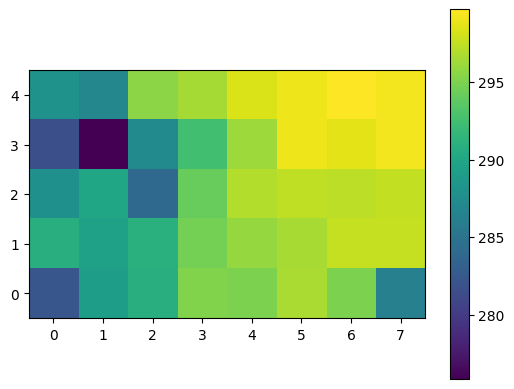

In [66]:
plt.imshow(training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][0][indx_inspec,23,:,:,1], cmap = 'viridis', origin="lower")
plt.colorbar()

In [67]:
indx_inspec

748

In [68]:
training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][indx_inspec][23]

numpy.datetime64('2014-06-08T00:00:00.000000000')

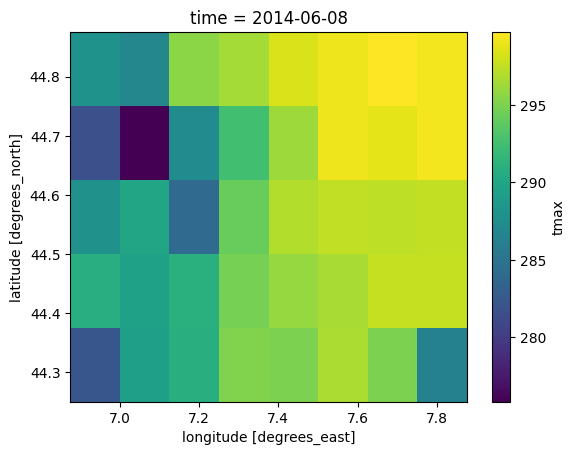

In [70]:
meteorological_ds[var].loc[training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][indx_inspec][23]].plot(cmap = 'viridis')

In [71]:
# tot_rain, tot_snow, mean_temp
check_meteo_var = ["prec", "tmax", "tmin"]


for j in range(len(check_meteo_var)):

  for lag in range(0,past_meteo_images):
        check_raster  = [np.equal(meteorological_ds[check_meteo_var[j]].sel(time = training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][i][lag]).values,
                                  training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][0][i][lag,:,:,j]).all() for i in range(0,len(training_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][:,0]))]
        if not all(check_raster):
          print("Inconsistency at lag: " + str(lag) + " for the variable: " + str(check_meteo_var[j]))


  if all(check_raster):
    print(check_meteo_var[j], " OK")

prec  OK
tmax  OK
tmin  OK


In [72]:
check_meteo_var = ["prec", "tmax", "tmin"]


for j in range(len(check_meteo_var)):

  for lag in range(0,past_meteo_images):
        check_raster  = [np.equal(meteorological_ds[check_meteo_var[j]].sel(time = validation_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][i][lag]).values,
                                  validation_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][0][i][lag,:,:,j]).all() for i in range(0,len(validation_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][:,0]))]
        if not all(check_raster):
          print("Inconsistency at lag: " + str(lag) + " for the variable: " + str(check_meteo_var[j]))


  if all(check_raster):
    print(check_meteo_var[j], " OK")

prec  OK
tmax  OK
tmin  OK


In [73]:
check_meteo_var = ["prec", "tmax", "tmin"]


for j in range(len(check_meteo_var)):

  for lag in range(0,past_meteo_images):
        check_raster  = [np.equal(meteorological_ds[check_meteo_var[j]].sel(time = test_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][1][i][lag]).values,
                                  test_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][0][i][lag,:,:,j]).all() for i in range(0,len(test_target_numpy_dates_dictionary[sensor_id_list[selected_sensor_number]][:,0]))]
        if not all(check_raster):
          print("Inconsistency at lag: " + str(lag) + " for the variable: " + str(check_meteo_var[j]))


  if all(check_raster):
    print(check_meteo_var[j], " OK")

prec  OK
tmax  OK
tmin  OK


In [74]:
del check_raster

#### Plots

In [75]:
selected_sensor_number = 2

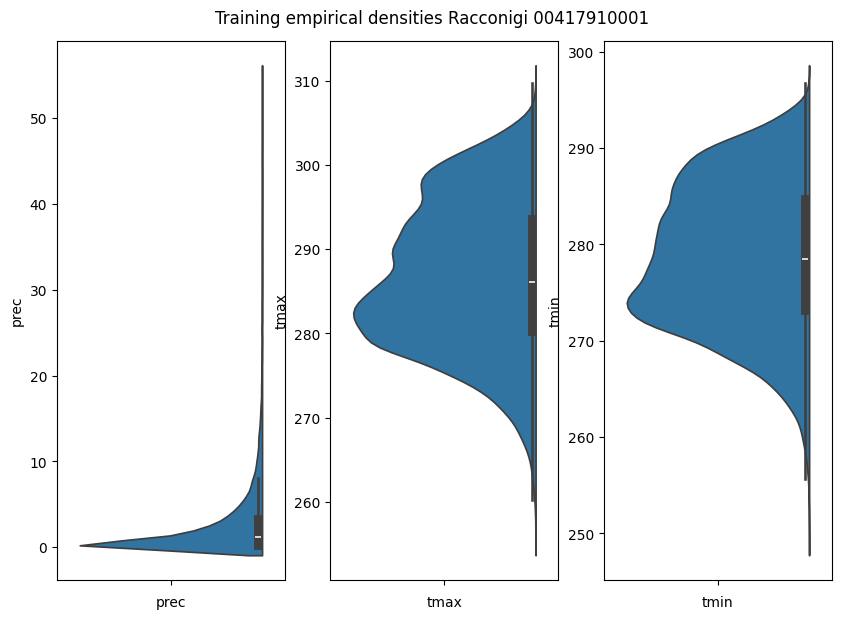

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(training_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = training_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Training empirical densities " + sensor_municipalities_id_codes[selected_sensor_number], y = 0.925)
plt.show()

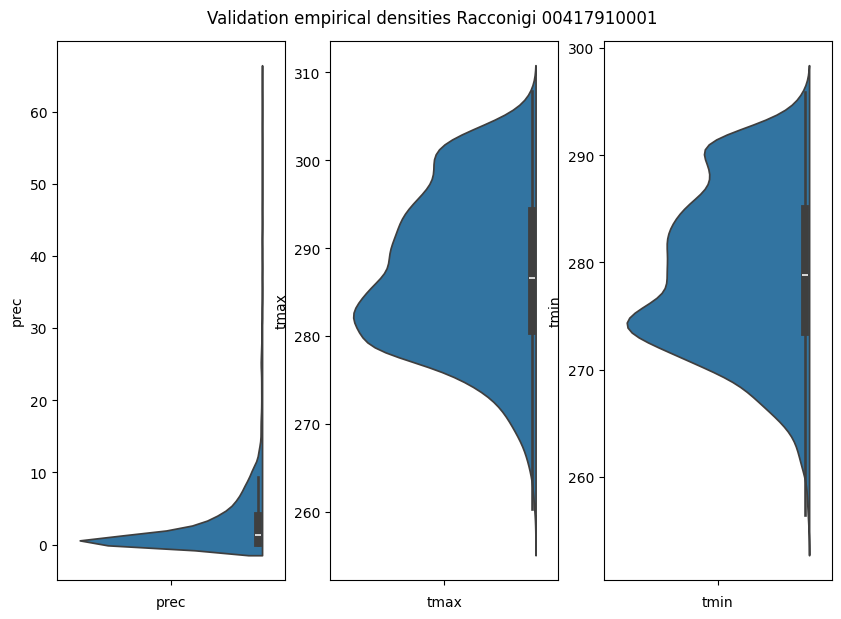

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(validation_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = validation_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Validation empirical densities " + sensor_municipalities_id_codes[selected_sensor_number], y = 0.925)
plt.show()

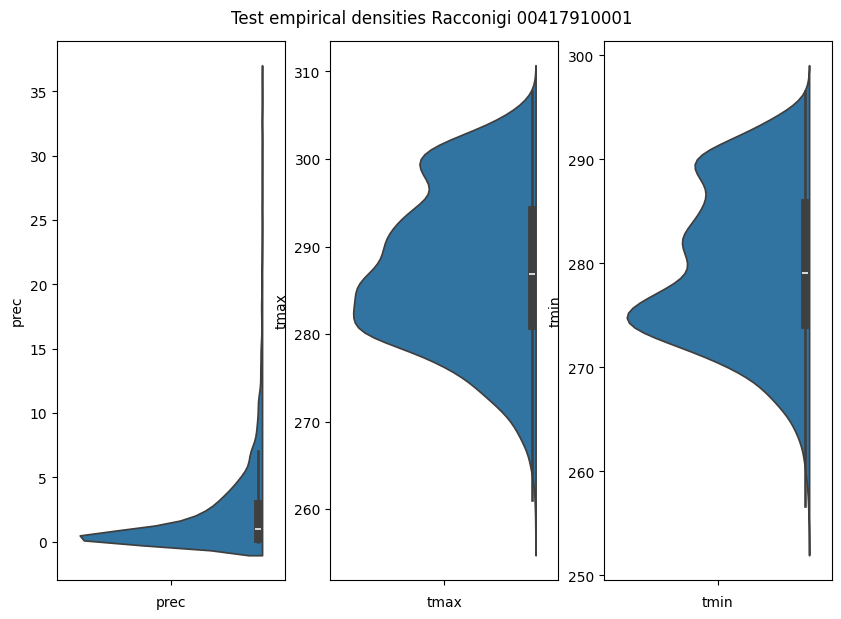

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(test_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = test_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Test empirical densities " + sensor_municipalities_id_codes[selected_sensor_number], y = 0.925)
plt.show()

# Normalizations

Normalize the data computing z-score

#### check tmax > tmin before normalization

In [76]:
all([np.greater(training_meteo_features_dictionary[sensor_id_list[i]][0][:,:,:,:,1],
         training_meteo_features_dictionary[sensor_id_list[i]][0][:,:,:,:,2]).all() for i in range(len(sensor_id_list))])

True

In [77]:
all([np.greater(validation_meteo_features_dictionary[sensor_id_list[i]][0][:,:,:,:,1],
         validation_meteo_features_dictionary[sensor_id_list[i]][0][:,:,:,:,2]).all() for i in range(len(sensor_id_list))])

True

In [78]:
all([np.greater(test_meteo_features_dictionary[sensor_id_list[i]][0][:,:,:,:,1],
         test_meteo_features_dictionary[sensor_id_list[i]][0][:,:,:,:,2]).all() for i in range(len(sensor_id_list))])

True

### Meteo

Z-scores

In [79]:
# Normalization factors:
training_meteo_features_dictionary_means = dict()
training_meteo_features_dictionary_std = dict()

# Initilization of meteorological input objects
training_meteo_features_dictionary_normalized = copy.deepcopy(training_meteo_features_dictionary)
training_meteo_features_dictionary_unique_pairs_normalized = copy.deepcopy(training_meteo_features_dictionary_unique_pairs)

validation_meteo_features_dictionary_normalized = copy.deepcopy(validation_meteo_features_dictionary)
validation_meteo_features_dictionary_unique_pairs_normalized = copy.deepcopy(validation_meteo_features_dictionary_unique_pairs)

test_meteo_features_dictionary_normalized = copy.deepcopy(test_meteo_features_dictionary)
test_meteo_features_dictionary_unique_pairs_normalized = copy.deepcopy(test_meteo_features_dictionary_unique_pairs)


for i in range(len(sensor_id_list)):
  # Means
  training_meteo_features_dictionary_means[sensor_id_list[i]] = training_meteo_features_dictionary_unique_pairs[sensor_id_list[i]].mean()
  ## Compute unique Mean for tmax and tmin
  all_temperature_array = training_meteo_features_dictionary_unique_pairs[sensor_id_list[i]][["tmax","tmin"]].to_array(dim='all_temp')
  temp_mean = all_temperature_array.mean()
  training_meteo_features_dictionary_means[sensor_id_list[i]] = training_meteo_features_dictionary_means[sensor_id_list[i]].assign(tmax=temp_mean)
  training_meteo_features_dictionary_means[sensor_id_list[i]] = training_meteo_features_dictionary_means[sensor_id_list[i]].assign(tmin=temp_mean)

  # Standard deviations
  training_meteo_features_dictionary_std[sensor_id_list[i]] = training_meteo_features_dictionary_unique_pairs[sensor_id_list[i]].std()
  ## Compute unique std for tmax and tmin
  temp_std = all_temperature_array.std()
  training_meteo_features_dictionary_std[sensor_id_list[i]] = training_meteo_features_dictionary_std[sensor_id_list[i]].assign(tmax=temp_std)
  training_meteo_features_dictionary_std[sensor_id_list[i]] = training_meteo_features_dictionary_std[sensor_id_list[i]].assign(tmin=temp_std)


  # Compute z-scores
  training_meteo_features_dictionary_normalized[sensor_id_list[i]][0] = (training_meteo_features_dictionary_normalized[sensor_id_list[i]][0] - training_meteo_features_dictionary_means[sensor_id_list[i]].to_array().values)/training_meteo_features_dictionary_std[sensor_id_list[i]].to_array().values
  training_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[i]] = (training_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[i]] - training_meteo_features_dictionary_means[sensor_id_list[i]])/training_meteo_features_dictionary_std[sensor_id_list[i]]

  validation_meteo_features_dictionary_normalized[sensor_id_list[i]][0] = (validation_meteo_features_dictionary_normalized[sensor_id_list[i]][0] - training_meteo_features_dictionary_means[sensor_id_list[i]].to_array().values)/training_meteo_features_dictionary_std[sensor_id_list[i]].to_array().values
  validation_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[i]] = (validation_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[i]] - training_meteo_features_dictionary_means[sensor_id_list[i]])/training_meteo_features_dictionary_std[sensor_id_list[i]]

  test_meteo_features_dictionary_normalized[sensor_id_list[i]][0] = (test_meteo_features_dictionary_normalized[sensor_id_list[i]][0] - training_meteo_features_dictionary_means[sensor_id_list[i]].to_array().values)/training_meteo_features_dictionary_std[sensor_id_list[i]].to_array().values
  test_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[i]] = (test_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[i]] - training_meteo_features_dictionary_means[sensor_id_list[i]])/training_meteo_features_dictionary_std[sensor_id_list[i]]


In [80]:
selected_sensor_number = 2

In [81]:
training_meteo_features_dictionary_means[sensor_id_list[selected_sensor_number]]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 2.564
    tmax     float32 282.7
    tmin     float32 282.7

In [82]:
training_meteo_features_dictionary_std[sensor_id_list[selected_sensor_number]]

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 3.831
    tmax     float32 9.083
    tmin     float32 9.083

In [ ]:
training_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 -6.43e-08
    tmax     float32 0.4428
    tmin     float32 -0.4428

In [ ]:
validation_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 0.09603
    tmax     float32 0.5101
    tmin     float32 -0.3889

In [ ]:
test_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 -0.102
    tmax     float32 0.5278
    tmin     float32 -0.3301

In [ ]:
training_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].std()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 1.0
    tmax     float32 0.9658
    tmin     float32 0.8216

In [ ]:
validation_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].std()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 1.177
    tmax     float32 0.9784
    tmin     float32 0.8253

In [ ]:
test_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].std()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    prec     float32 0.8255
    tmax     float32 0.965
    tmin     float32 0.8208

### Water Table

In [ ]:
# Compute the statistics and z-score for each time series (each sensor)
# Save the statistics and the z-score in new dictionary, with keys equal to the identification number of each sensor

In [83]:
# Normalization Factors
training_target_dictionary_means = dict()
training_target_dictionary_std = dict()

# Initilization of target normalized arrays
training_target_numpy_values_dictionary_normalized = copy.deepcopy(training_target_numpy_values_dictionary)
validation_target_numpy_values_dictionary_normalized = copy.deepcopy(validation_target_numpy_values_dictionary)
test_target_numpy_values_dictionary_normalized = copy.deepcopy(test_target_numpy_values_dictionary)

training_target_numpy_dates_dictionary_unique_pairs_normalized = copy.deepcopy(training_target_ds_dictionary_unique_pairs)
validation_target_numpy_dates_dictionary_unique_pairs_normalized = copy.deepcopy(validation_target_ds_dictionary_unique_pairs)
test_target_numpy_dates_dictionary_unique_pairs_normalized = copy.deepcopy(test_target_ds_dictionary_unique_pairs)
all_sets_target_numpy_dates_dictionary_unique_pairs_normalized = copy.deepcopy(all_sets_target_ds_dictionary_unique_pairs)

for i in range(len(sensor_id_list)):
  # Means
  training_target_dictionary_means[sensor_id_list[i]] = training_target_ds_dictionary_unique_pairs[sensor_id_list[i]]["Value"].mean()
  # Standard deviations
  training_target_dictionary_std[sensor_id_list[i]] = training_target_ds_dictionary_unique_pairs[sensor_id_list[i]]["Value"].std()

  # Compute z-scores
  training_target_numpy_values_dictionary_normalized[sensor_id_list[i]] = (training_target_numpy_values_dictionary_normalized[sensor_id_list[i]] - training_target_dictionary_means[sensor_id_list[i]])/training_target_dictionary_std[sensor_id_list[i]]
  training_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] = (training_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] - training_target_dictionary_means[sensor_id_list[i]])/training_target_dictionary_std[sensor_id_list[i]]

  validation_target_numpy_values_dictionary_normalized[sensor_id_list[i]] = (validation_target_numpy_values_dictionary_normalized[sensor_id_list[i]] - training_target_dictionary_means[sensor_id_list[i]])/training_target_dictionary_std[sensor_id_list[i]]
  validation_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] = (validation_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] - training_target_dictionary_means[sensor_id_list[i]])/training_target_dictionary_std[sensor_id_list[i]]

  test_target_numpy_values_dictionary_normalized[sensor_id_list[i]] = (test_target_numpy_values_dictionary_normalized[sensor_id_list[i]] - training_target_dictionary_means[sensor_id_list[i]])/training_target_dictionary_std[sensor_id_list[i]]
  test_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] = (test_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] - training_target_dictionary_means[sensor_id_list[i]])/training_target_dictionary_std[sensor_id_list[i]]

  all_sets_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] = (all_sets_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"] - training_target_dictionary_means[sensor_id_list[i]])/training_target_dictionary_std[sensor_id_list[i]]


In [84]:
selected_sensor_number = 2

In [85]:
training_target_numpy_values_dictionary_normalized[sensor_id_list[selected_sensor_number]].mean()

-1.0624938104823927e-15

In [ ]:
validation_target_numpy_values_dictionary_normalized[sensor_id_list[selected_sensor_number]].mean()

-0.12541300220458268

In [ ]:
test_target_numpy_values_dictionary_normalized[sensor_id_list[selected_sensor_number]].mean()

1.2295238802949056

In [ ]:
training_target_numpy_values_dictionary_normalized[sensor_id_list[selected_sensor_number]].std()

0.9993322202928082

In [ ]:
validation_target_numpy_values_dictionary_normalized[sensor_id_list[selected_sensor_number]].std()

0.6627714755243431

In [ ]:
test_target_numpy_values_dictionary_normalized[sensor_id_list[selected_sensor_number]].std()

0.7219569611758929

In [86]:
# print the means
print("Training Means [m]: ")
for i in range(len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i], ":", end = "")
  print(round(training_target_dictionary_means[sensor_id_list[i]], 3))

Training Means [m]: 
Savigliano 00421510001 :3.771
Vottignasco 00425010001 :4.427
Racconigi 00417910001 :4.54


In [ ]:
# print the standard deviations
print("Training Standard Deviation [m]: ")
for i in range(len(sensor_id_list)):
  print(sensor_municipalities_id_codes[i], ":", end = "")
  print(round(training_target_dictionary_std[sensor_id_list[i]], 3))

Training Standard Deviation [m]: 
Savigliano 00421510001 :0.268
Vottignasco 00425010001 :0.754
Racconigi 00417910001 :0.761


# Plots & checks

#### tmax > tmin

In [87]:
all([np.greater(training_meteo_features_dictionary_normalized[sensor_id_list[i]][0][:,:,:,:,1],
         training_meteo_features_dictionary_normalized[sensor_id_list[i]][0][:,:,:,:,2]).all() for i in range(len(sensor_id_list))])

True

In [88]:
all([np.greater(validation_meteo_features_dictionary_normalized[sensor_id_list[i]][0][:,:,:,:,1],
         validation_meteo_features_dictionary_normalized[sensor_id_list[i]][0][:,:,:,:,2]).all() for i in range(len(sensor_id_list))])

True

In [89]:
all([np.greater(test_meteo_features_dictionary_normalized[sensor_id_list[i]][0][:,:,:,:,1],
         test_meteo_features_dictionary_normalized[sensor_id_list[i]][0][:,:,:,:,2]).all() for i in range(len(sensor_id_list))])

True

#### Plots

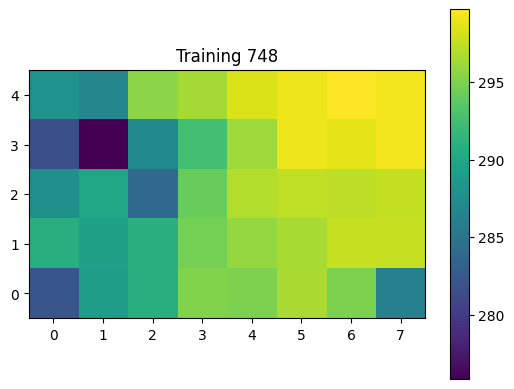

In [90]:
plt.imshow(training_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][0][indx_inspec,23,:,:,1], cmap = 'viridis', origin="lower")
plt.colorbar()
plt.title(f"Training {indx_inspec}")
plt.show()

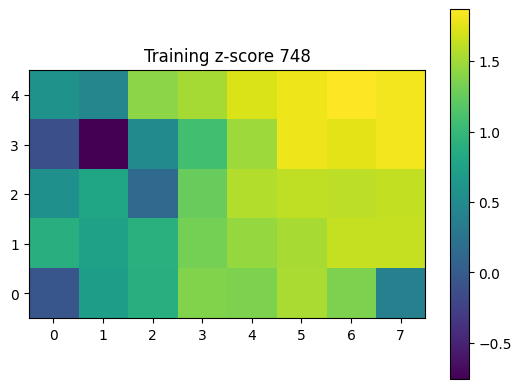

In [91]:
plt.imshow(training_meteo_features_dictionary_normalized[sensor_id_list[selected_sensor_number]][0][indx_inspec,23,:,:,1], cmap = 'viridis', origin="lower")
plt.colorbar()
plt.title(f"Training z-score {indx_inspec}")
plt.show()

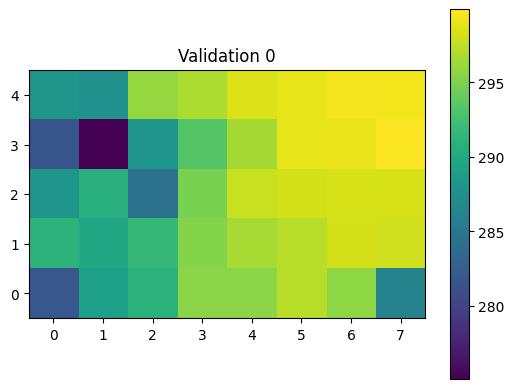

In [92]:
plt.imshow(validation_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][0][0,23,:,:,1], cmap = 'viridis', origin="lower")
plt.colorbar()
plt.title("Validation 0")
plt.show()

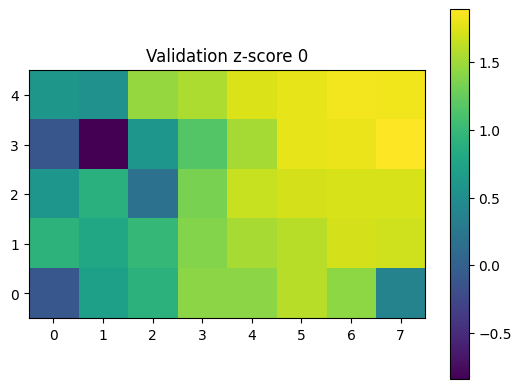

In [93]:
plt.imshow(validation_meteo_features_dictionary_normalized[sensor_id_list[selected_sensor_number]][0][0,23,:,:,1], cmap = 'viridis', origin="lower")
plt.colorbar()
plt.title("Validation z-score 0")
plt.show()

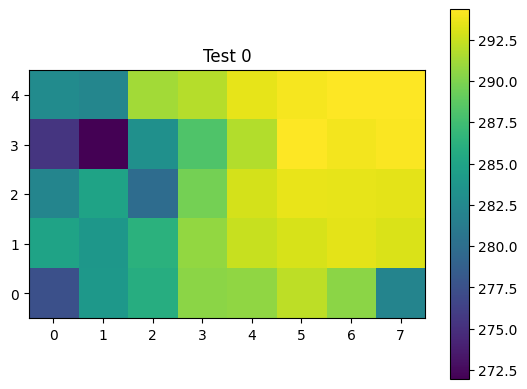

In [94]:
plt.imshow(test_meteo_features_dictionary[sensor_id_list[selected_sensor_number]][0][0,23,:,:,1], cmap = 'viridis', origin="lower")
plt.colorbar()
plt.title("Test 0")
plt.show()

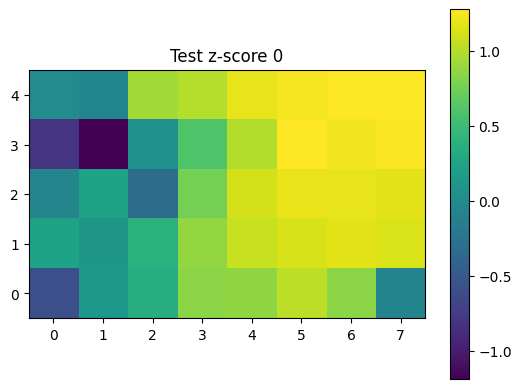

In [95]:
plt.imshow(test_meteo_features_dictionary_normalized[sensor_id_list[selected_sensor_number]][0][0,23,:,:,1], cmap = 'viridis', origin="lower")
plt.colorbar()
plt.title("Test z-score 0")
plt.show()

### Violins

In [ ]:
selected_sensor_number = 2

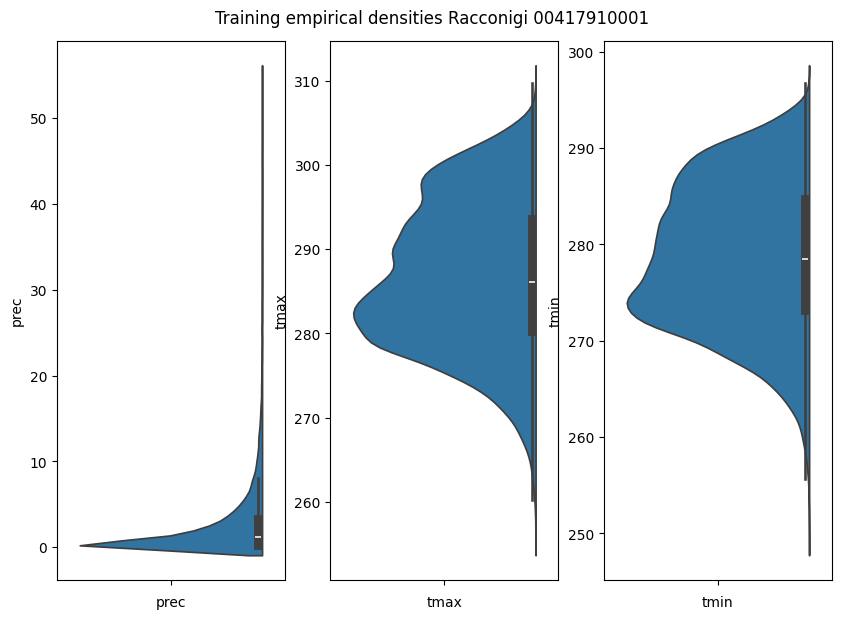

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(training_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = training_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Training empirical densities " + sensor_municipalities_id_codes[selected_sensor_number], y = 0.925)
plt.show()

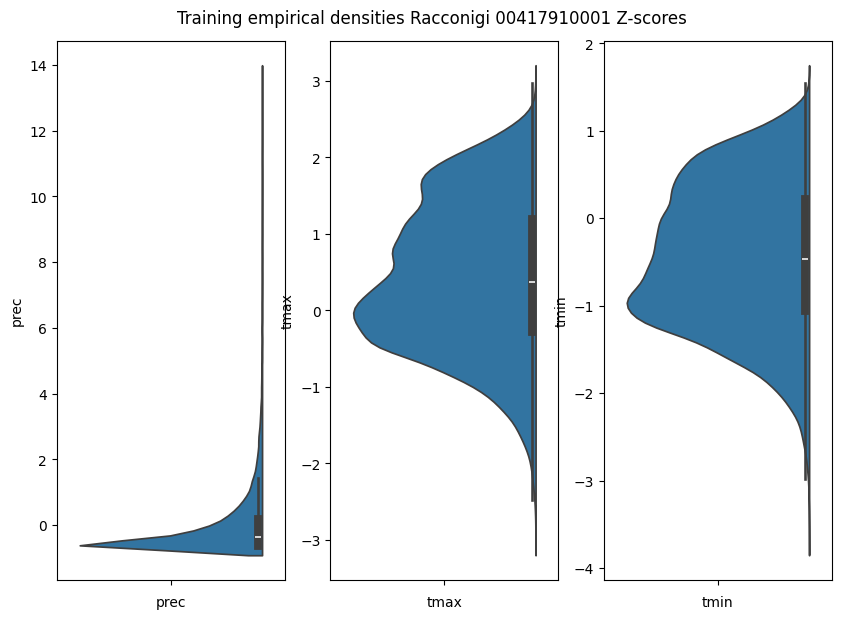

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(training_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = training_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Training empirical densities " + sensor_municipalities_id_codes[selected_sensor_number] + " Z-scores", y = 0.925)
plt.show()

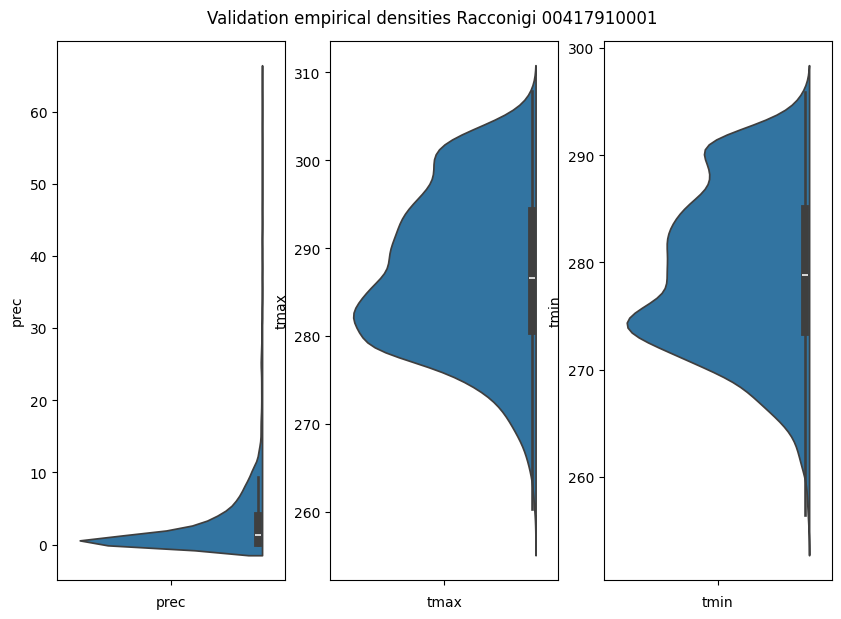

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(validation_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = validation_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Validation empirical densities " + sensor_municipalities_id_codes[selected_sensor_number], y = 0.925)
plt.show()

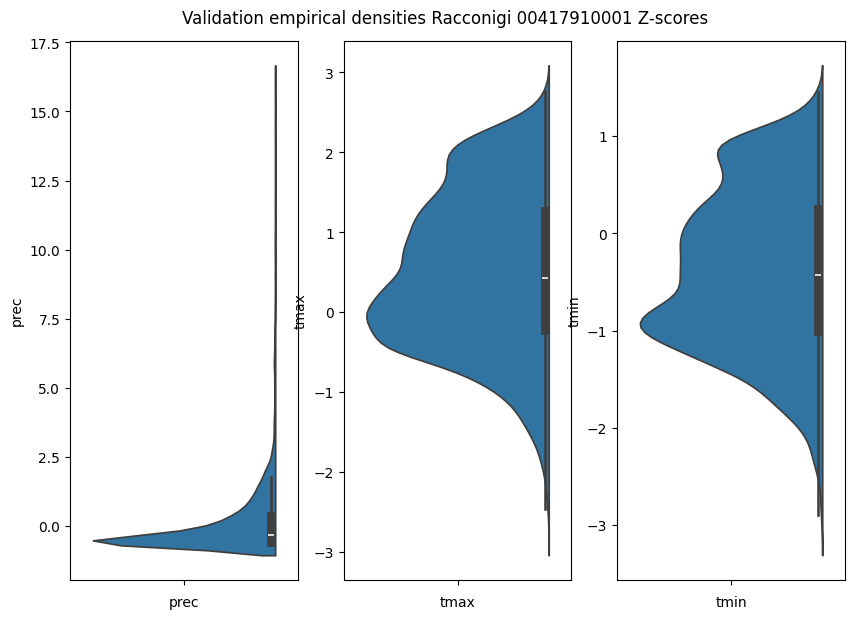

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(validation_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = validation_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Validation empirical densities " + sensor_municipalities_id_codes[selected_sensor_number] + " Z-scores", y = 0.925)
plt.show()

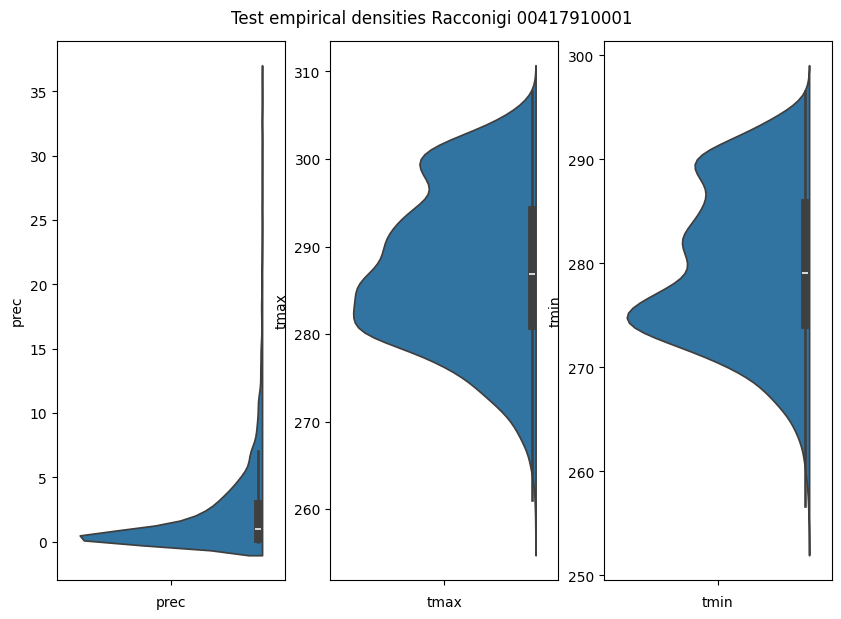

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(test_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = test_meteo_features_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Test empirical densities " + sensor_municipalities_id_codes[selected_sensor_number], y = 0.925)
plt.show()

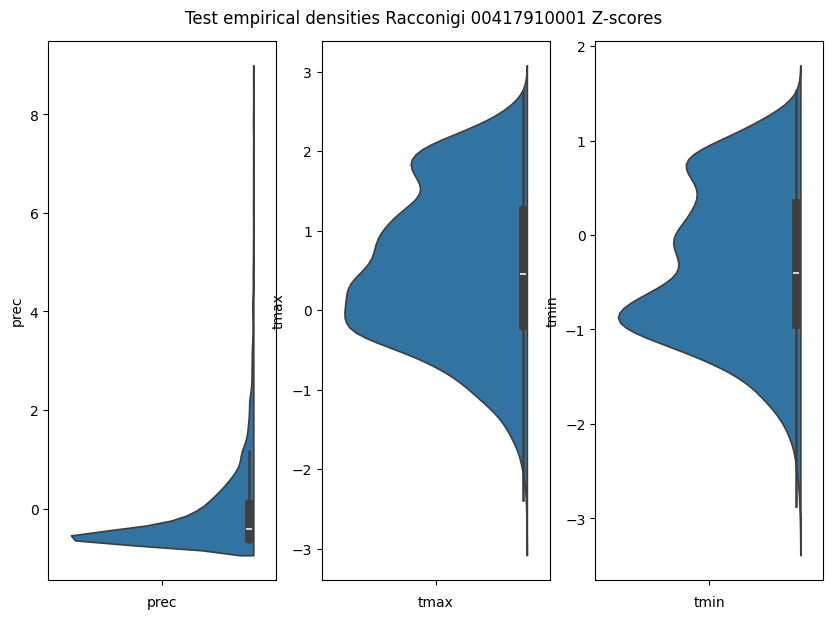

In [ ]:
# Violin plots
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
all_varibles = list(test_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]].keys())

for var in all_varibles:
    ds = test_meteo_features_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]][var].to_dataframe()
    ds = ds.dropna()

    sns.violinplot(y = var, data = ds, density_norm = "area",
                  split=True, legend = False, ax=axes[all_varibles.index(var)], ) #, width=1.5
    axes[all_varibles.index(var)].set(xlabel=var)

fig.suptitle("Test empirical densities " + sensor_municipalities_id_codes[selected_sensor_number] + " Z-scores", y = 0.925)
plt.show()

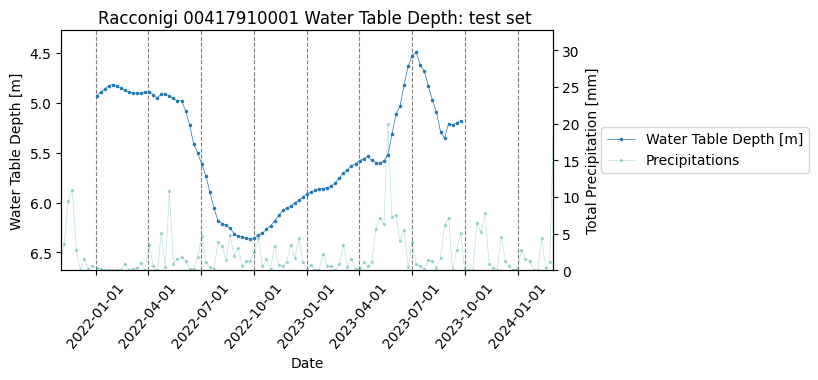

In [ ]:
plot_ts_with_gaps(y = test_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = test_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_titles[selected_sensor_number] + ": test set", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05,
                  linewidth = 0.5, x_legend = 1.535, xticks_freq = "QS",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

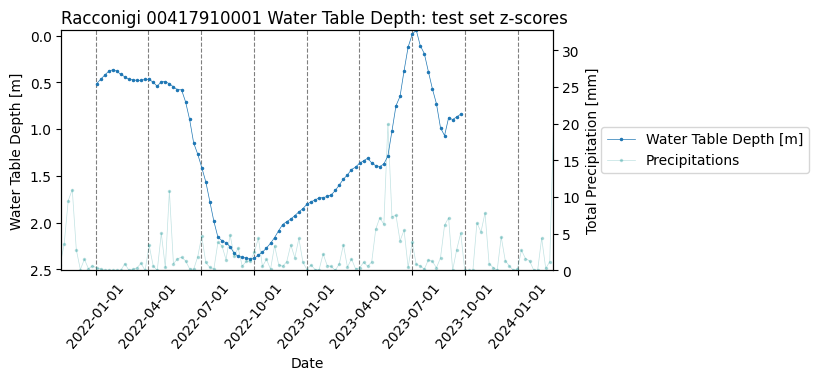

In [ ]:
plot_ts_with_gaps(y = test_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = test_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]]["Date"].values,
                  label_base_series = "Water Table Depth [m]",
                  title = sensor_titles[selected_sensor_number] + ": test set z-scores", width = 6,
                  height = 3, temp_freq='W', y_lim = 0.05,
                  linewidth = 0.5, x_legend = 1.535, xticks_freq = "QS",
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values)

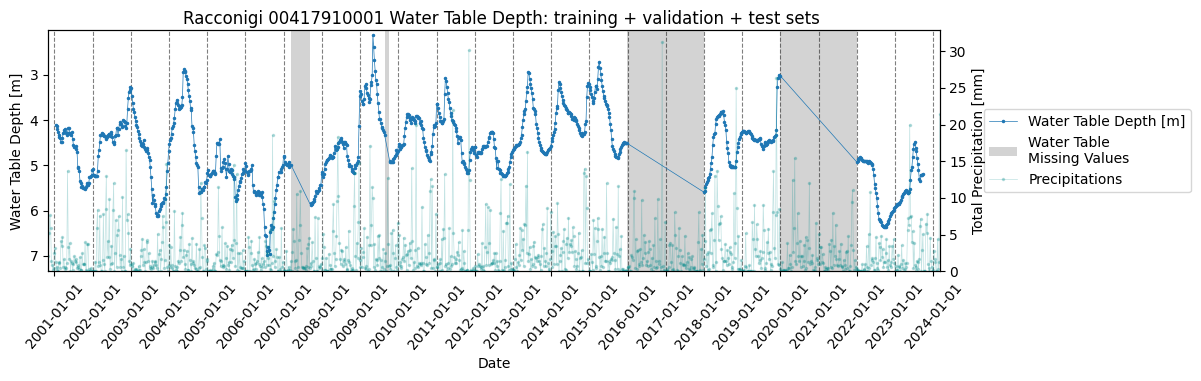

In [ ]:
plot_ts_with_gaps(y = all_sets_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = all_sets_target_ds_dictionary_unique_pairs[sensor_id_list[selected_sensor_number]]["Date"].values,
                  title = sensor_titles[selected_sensor_number] + ": training + validation + test sets",
                  label_base_series = "Water Table Depth [m]",
                  width = 10, height = 3, temp_freq='W',
                  y_lim = 0.05, linewidth = 0.5, x_legend = 1.29,
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values,
                  reverse_axis=True)

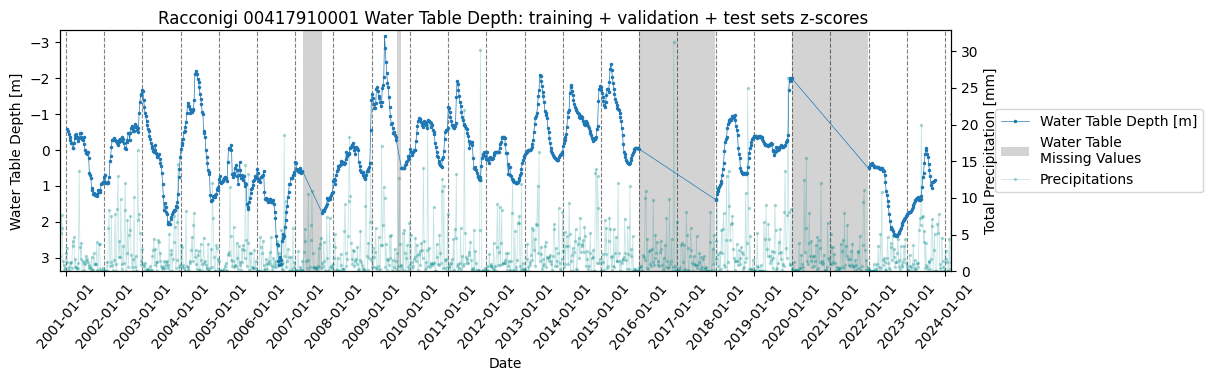

In [ ]:
plot_ts_with_gaps(y = all_sets_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]]["Value"].values,
                  date = all_sets_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[selected_sensor_number]]["Date"].values,
                  title = sensor_titles[selected_sensor_number] + ": training + validation + test sets z-scores",
                  label_base_series = "Water Table Depth [m]",
                  width = 10, height = 3, temp_freq='W',
                  y_lim = 0.05, linewidth = 0.5, x_legend = 1.29,
                  precipitations=weekly_mean_precipitations["prec"].values,
                  date_precipitations = weekly_mean_precipitations["Date"].values,
                  reverse_axis=True)

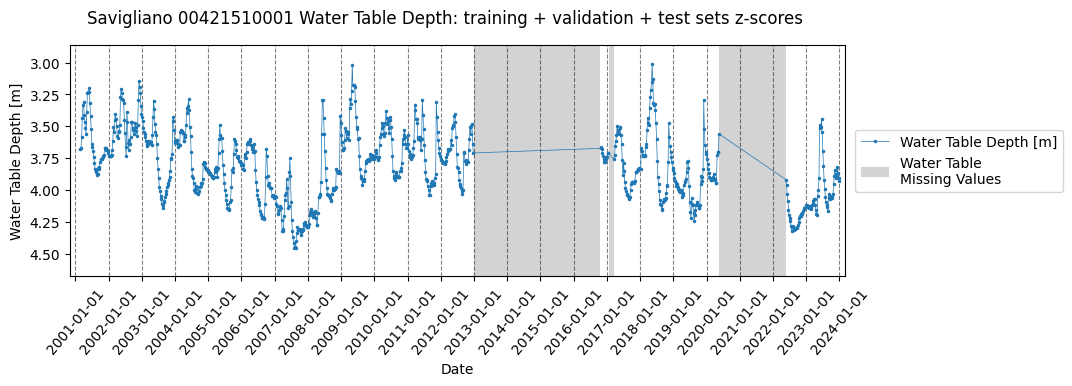

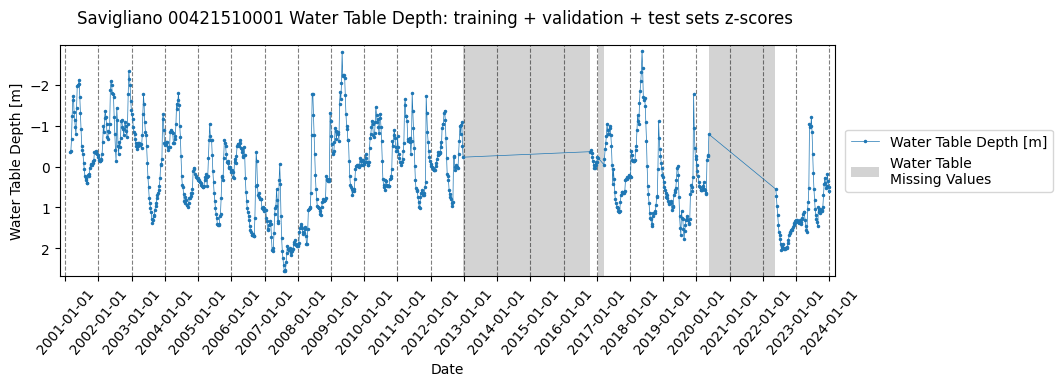

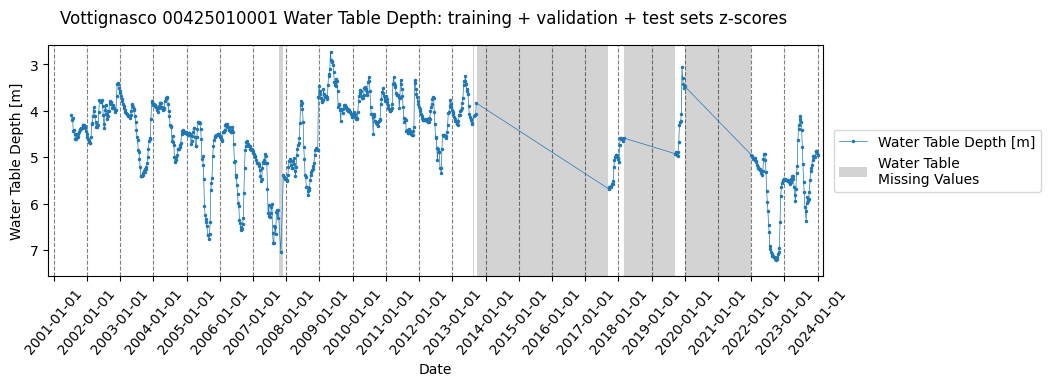

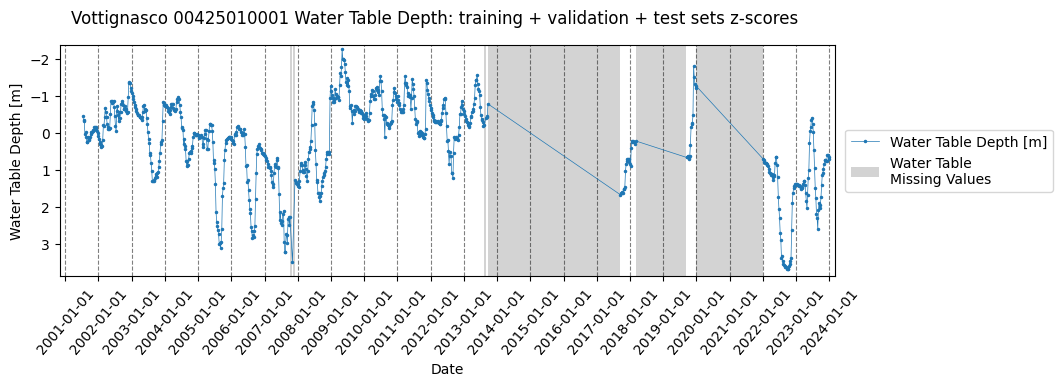

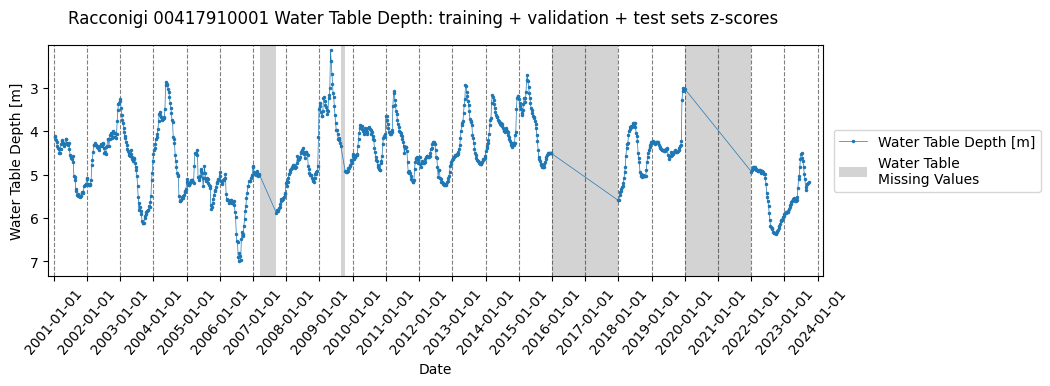

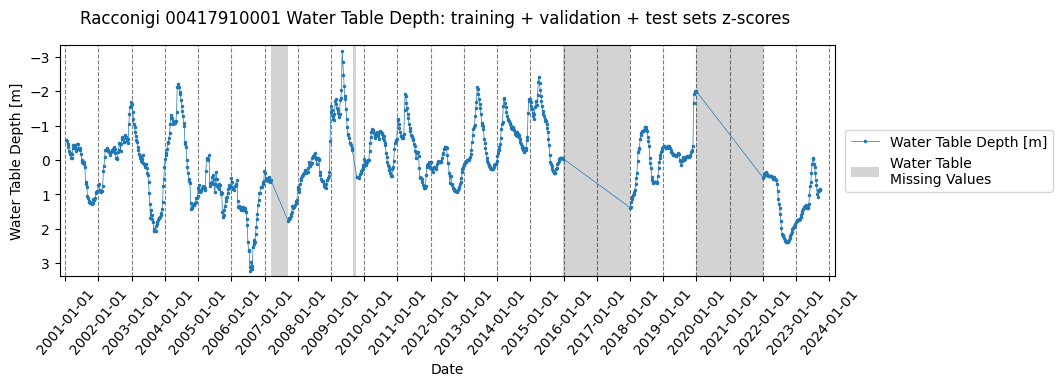

In [ ]:
for i in range(len(sensor_id_list)):

      plot_ts_with_gaps(y = all_sets_target_ds_dictionary_unique_pairs[sensor_id_list[i]]["Value"].values,
                  date = all_sets_target_ds_dictionary_unique_pairs[sensor_id_list[i]]["Date"].values,
                  title = sensor_titles[i] + ": training + validation + test sets z-scores",
                  label_base_series = "Water Table Depth [m]",
                  width = 10, height = 3, temp_freq='W',
                  y_lim = 0.05, linewidth = 0.5, x_legend = 1.29)

      plot_ts_with_gaps(y = all_sets_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"].values,
                  date = all_sets_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Date"].values,
                  title = sensor_titles[i] + ": training + validation + test sets z-scores",
                  label_base_series = "Water Table Depth [m]",
                  width = 10, height = 3, temp_freq='W',
                  y_lim = 0.05, linewidth = 0.5, x_legend = 1.29)

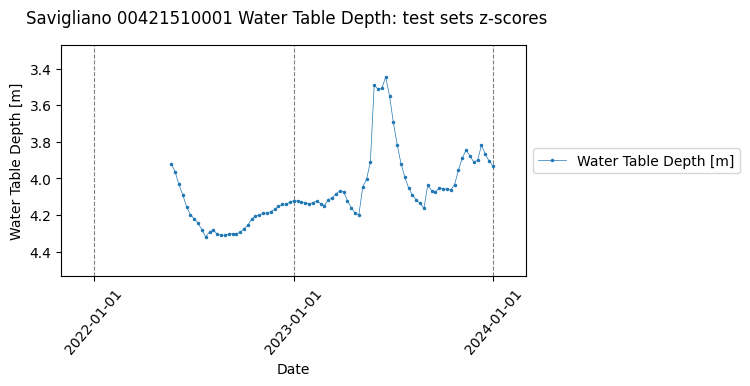

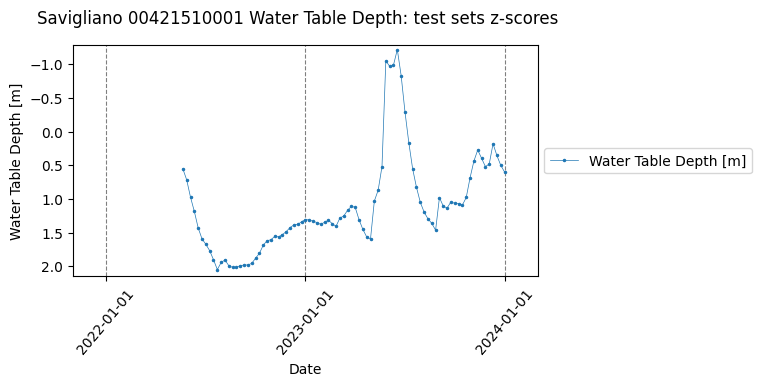

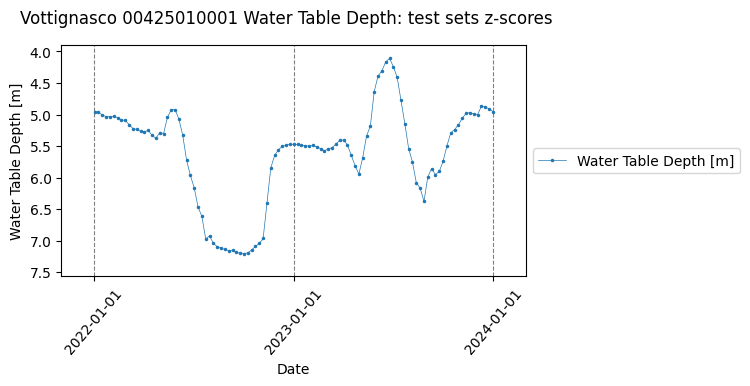

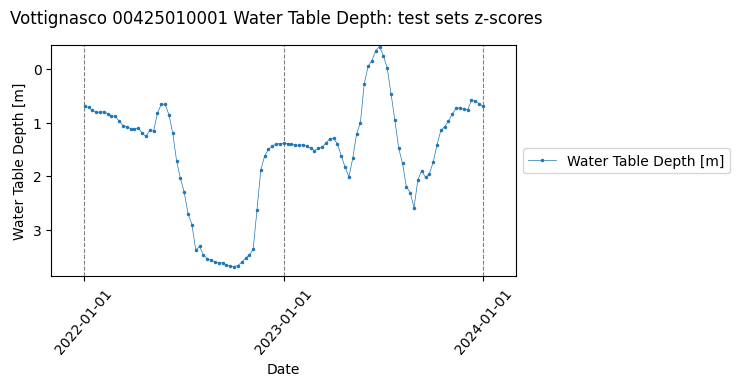

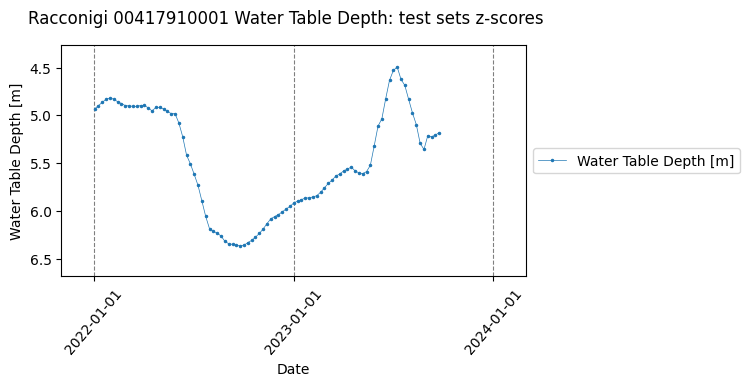

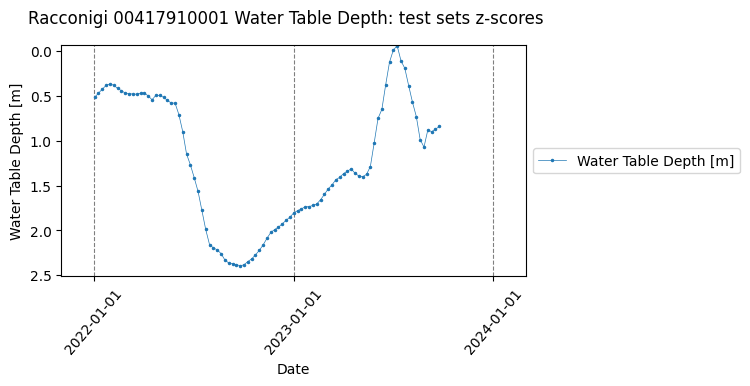

In [ ]:
for i in range(len(sensor_id_list)):

      plot_ts_with_gaps(y = test_target_ds_dictionary_unique_pairs[sensor_id_list[i]]["Value"].values,
                  date = test_target_ds_dictionary_unique_pairs[sensor_id_list[i]]["Date"].values,
                  title = sensor_titles[i] + ": test sets z-scores",
                  label_base_series = "Water Table Depth [m]",
                  width = 6, height = 3, temp_freq='W',
                  y_lim = 0.05, linewidth = 0.5, x_legend = 1.475)

      plot_ts_with_gaps(y = test_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Value"].values,
                  date = test_target_numpy_dates_dictionary_unique_pairs_normalized[sensor_id_list[i]]["Date"].values,
                  title = sensor_titles[i] + ": test sets z-scores",
                  label_base_series = "Water Table Depth [m]",
                  width = 6, height = 3, temp_freq='W',
                  y_lim = 0.05, linewidth = 0.5, x_legend = 1.475)

# Savings

In the following **uncomment** to save

In [ ]:
# For saving differente output (target) objects
if (step_ahead > 0):
  output_type = "seq2seq"
else:
  output_type = "seq2val"

In [ ]:
output_type

'seq2val'

## Target objects

### Full series

In [ ]:
# Save here the time aggregated time series in csv files
saving_pre_proc_GM_water_table_path

In [ ]:
water_table_time_series_path_file_names

['Savigliano_00421510001_Water_Table_Depth_Grana_Maira.csv',
 'Vottignasco_00425010001_Water_Table_Depth_Grana_Maira.csv',
 'Racconigi_00417910001_Water_Table_Depth_Grana_Maira.csv']

In [ ]:
water_table_time_series_path_file_names
#''.join((inputString_2[:9],'p',inputString_2[9:]))
sensor_saving_names = [saving_pre_proc_GM_water_table_path + water_table_time_series_path_file_names[i].replace(".csv", "_weekly_ARPA.csv") for i in range(0,len(sensor_titles))]
sensor_saving_names

In [ ]:
#save_values_from_dict(wt_depth_all_time_series_aggregated, sensor_id_list, sensor_saving_names, value_type="pandas")

### Splited objects

In [ ]:
f"{saving_split_path_target}{output_type}/"

In [ ]:
## numpy_value object file names
training_target_numpy_values_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_target_values.npy" for i in range(len(sensor_id_list))]
validation_target_numpy_values_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_target_values.npy" for i in range(len(sensor_id_list))]
test_target_numpy_values_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_target_values.npy" for i in range(len(sensor_id_list))]
test_target_numpy_values_file_names

In [ ]:
training_target_numpy_normalized_values_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_target_normalized_values.npy" for i in range(len(sensor_id_list))]
validation_target_numpy_normalized_values_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_target_normalized_values.npy" for i in range(len(sensor_id_list))]
test_target_numpy_normalized_values_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_target_normalized_values.npy" for i in range(len(sensor_id_list))]
test_target_numpy_normalized_values_file_names

In [ ]:
training_target_numpy_dates_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_target_dates.npy" for i in range(len(sensor_id_list))]
validation_target_numpy_dates_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_target_dates.npy" for i in range(len(sensor_id_list))]
test_target_numpy_dates_file_names = [f"{saving_split_path_target}{output_type}/" + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_target_dates.npy" for i in range(len(sensor_id_list))]
test_target_numpy_dates_file_names

In [ ]:
training_target_means_file_names = [saving_split_path_target + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_target_mean.npy" for i in range(len(sensor_id_list))]
training_target_std_file_names = [saving_split_path_target + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_target_std.npy" for i in range(len(sensor_id_list))]
training_target_std_file_names

In [ ]:
training_target_ds_unique_pairs_file_names = [saving_split_path_target + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_target_ds.csv" for i in range(len(sensor_id_list))]
validation_target_ds_unique_pairs_file_names = [saving_split_path_target + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_target_ds.csv" for i in range(len(sensor_id_list))]
test_target_ds_unique_pairs_file_names = [saving_split_path_target + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_target_ds.csv" for i in range(len(sensor_id_list))]
all_sets_target_ds_unique_pairs_file_names = [saving_split_path_target + sensor_municipalities_id_codes[i].replace(" ","_") + "_all_sets_target_ds.csv" for i in range(len(sensor_id_list))]
all_sets_target_ds_unique_pairs_file_names

In [ ]:
# # # numpy_value and date

# # # Training

# print("\nTraining split saving ")
# print("Values objects: ")
# save_values_from_dict(ds_dict = training_target_numpy_values_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_target_numpy_values_file_names,
#                       value_type = "numpy")

# print("Normalized values_objects: ")
# save_values_from_dict(ds_dict = training_target_numpy_values_dictionary_normalized,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_target_numpy_normalized_values_file_names,
#                       value_type = "numpy")

# print("Normalization factors MEAN: ")
# save_values_from_dict(ds_dict = training_target_dictionary_means,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_target_means_file_names,
#                       value_type = "numpy")

# print("Normalization factors STD: ")
# save_values_from_dict(ds_dict = training_target_dictionary_std,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_target_std_file_names,
#                       value_type = "numpy")

# print("Dates objects: ")
# save_values_from_dict(ds_dict = training_target_numpy_dates_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_target_numpy_dates_file_names,
#                       value_type = "numpy")

# print("Unique pairs objects: ")
# save_values_from_dict(ds_dict = training_target_ds_dictionary_unique_pairs,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_target_ds_unique_pairs_file_names,
#                       value_type = "pandas")

# # Validation
# print("\nValidation split saving ")
# print("Values objects: ")
# save_values_from_dict(ds_dict = validation_target_numpy_values_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_target_numpy_values_file_names,
#                       value_type = "numpy")

# print("Normalized values objects: ")
# save_values_from_dict(ds_dict = validation_target_numpy_values_dictionary_normalized,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_target_numpy_normalized_values_file_names,
#                       value_type = "numpy")

# print("Dates objects: ")
# save_values_from_dict(ds_dict = validation_target_numpy_dates_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_target_numpy_dates_file_names,
#                       value_type = "numpy")

# print("Unique pairs objects: ")
# save_values_from_dict(ds_dict = validation_target_ds_dictionary_unique_pairs,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_target_ds_unique_pairs_file_names,
#                       value_type = "pandas")

# # Test
# print("\nTest split saving ")
# print("Values objects: ")
# save_values_from_dict(ds_dict = test_target_numpy_values_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_target_numpy_values_file_names,
#                       value_type = "numpy")

# print("Normalized values objects: ")
# save_values_from_dict(ds_dict = test_target_numpy_values_dictionary_normalized,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_target_numpy_normalized_values_file_names,
#                       value_type = "numpy")

# print("Dates objects: ")
# save_values_from_dict(ds_dict = test_target_numpy_dates_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_target_numpy_dates_file_names,
#                       value_type = "numpy")

# print("Unique pairs objects: ")
# save_values_from_dict(ds_dict = test_target_ds_dictionary_unique_pairs,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_target_ds_unique_pairs_file_names,
#                       value_type = "pandas")

# # All sets
# print("\nAll sets ")
# print("Unique pairs objects: ")
# save_values_from_dict(ds_dict = all_sets_target_ds_dictionary_unique_pairs,
#                       keys_list = sensor_id_list,
#                       sensors_path = all_sets_target_ds_unique_pairs_file_names,
#                       value_type = "pandas")

## Features objects

### Full objects

In [ ]:
saving_pre_proc_GM_meteo_path

In [ ]:
# meteorological_ds.to_netcdf(saving_pre_proc_GM_meteo_path + 'meteo_data_GM_weekly.nc')

In [ ]:
# weekly_mean_precipitations.to_csv(saving_pre_proc_GM_meteo_path + 'weekly_mean_precipitations_GM.csv', index = False)

### Splitted objects

In [ ]:
# We need to store the first and the third (last) elementes of the feature list object
# Remember the list structure:
 # 1) A numpy-array (samples, past_meteo_images, height, width, variables) with the image time series for each sample
 # 2) A list with "samples" element, each element contains the dates of each image in the image time series of the corresponding sample
 # 3) A numpy-array (samles, past_meteo_images, 11) contains the one hot encoding of the months in each image time series

In [ ]:
training_meteo_features_image_sequences_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_image_sequences.npy" for i in range(len(sensor_id_list))]
validation_meteo_features_image_sequences_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_image_sequences.npy" for i in range(len(sensor_id_list))]
test_meteo_features_image_sequences_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_image_sequences.npy" for i in range(len(sensor_id_list))]
test_meteo_features_image_sequences_file_names

In [ ]:
training_meteo_features_normalized_image_sequences_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_normalized_image_sequences.npy" for i in range(len(sensor_id_list))]
validation_meteo_features_normalized_image_sequences_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_normalized_image_sequences.npy" for i in range(len(sensor_id_list))]
test_meteo_features_normalized_image_sequences_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_normalized_image_sequences.npy" for i in range(len(sensor_id_list))]
test_meteo_features_normalized_image_sequences_file_names

In [ ]:
training_meteo_features_dates_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_image_sequences_dates.npy" for i in range(len(sensor_id_list))]
validation_meteo_features_dates_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_image_sequences_dates.npy" for i in range(len(sensor_id_list))]
test_meteo_features_dates_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_image_sequences_dates.npy" for i in range(len(sensor_id_list))]
test_meteo_features_dates_file_names

In [ ]:
training_meteo_features_month_OHE_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_month_OHE.npy" for i in range(len(sensor_id_list))]
validation_meteo_features_month_OHE_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_month_OHE.npy" for i in range(len(sensor_id_list))]
test_meteo_features_month_OHE_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_month_OHE.npy" for i in range(len(sensor_id_list))]
test_meteo_features_month_OHE_file_names

In [ ]:
training_meteo_features_means_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_meteorological_means.nc" for i in range(len(sensor_id_list))]
training_meteo_features_std_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_meteorological_std.nc" for i in range(len(sensor_id_list))]
training_meteo_features_std_file_names

In [ ]:
training_meteo_features_ds_unique_pairs_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_training_meteorological_features_ds.nc" for i in range(len(sensor_id_list))]
validation_meteo_features_ds_unique_pairs_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_validation_meteorological_features_ds.nc" for i in range(len(sensor_id_list))]
test_meteo_features_ds_unique_pairs_file_names = [saving_split_path_features + sensor_municipalities_id_codes[i].replace(" ","_") + "_test_meteorological_features_ds.nc" for i in range(len(sensor_id_list))]
test_meteo_features_ds_unique_pairs_file_names

In [ ]:
saving_split_path_features

In [ ]:
# # Training
# print("\nTraining split savings ")
# print("Image sequences: ")
# save_values_from_dict(ds_dict = training_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_meteo_features_image_sequences_file_names,
#                       value_type = "feature_list",
#                       list_element = 0)

# print("Normalized image sequences: ")
# save_values_from_dict(ds_dict = training_meteo_features_dictionary_normalized,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_meteo_features_normalized_image_sequences_file_names,
#                       value_type = "feature_list",
#                       list_element = 0)

# print("Dates: ")
# save_values_from_dict(ds_dict = training_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_meteo_features_dates_file_names,
#                       value_type = "feature_list",
#                       list_element = 1)

# print("Month One Hot Encodings: ")
# save_values_from_dict(ds_dict = training_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_meteo_features_month_OHE_file_names,
#                       value_type = "feature_list",
#                       list_element = 2)

# print("Normalization factors MEAN: ")
# save_values_from_dict(ds_dict = training_meteo_features_dictionary_means,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_meteo_features_means_file_names,
#                       value_type = "xarray")

# print("Normalization factors STD: ")
# save_values_from_dict(ds_dict = training_meteo_features_dictionary_std,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_meteo_features_std_file_names,
#                       value_type = "xarray")

# print("Unique pairs objects: ")
# save_values_from_dict(ds_dict = training_meteo_features_dictionary_unique_pairs,
#                       keys_list = sensor_id_list,
#                       sensors_path = training_meteo_features_ds_unique_pairs_file_names,
#                       value_type = "xarray")


# # Validation
# print("\nValidation split savings ")
# print("Image sequences: ")
# save_values_from_dict(ds_dict = validation_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_meteo_features_image_sequences_file_names,
#                       value_type = "feature_list",
#                       list_element = 0)

# print("Normalized image sequences: ")
# save_values_from_dict(ds_dict = validation_meteo_features_dictionary_normalized,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_meteo_features_normalized_image_sequences_file_names,
#                       value_type = "feature_list",
#                       list_element = 0)

# print("Dates: ")
# save_values_from_dict(ds_dict = validation_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_meteo_features_dates_file_names,
#                       value_type = "feature_list",
#                       list_element = 1)

# print("Month One Hot Encodings: ")
# save_values_from_dict(ds_dict = validation_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_meteo_features_month_OHE_file_names,
#                       value_type = "feature_list",
#                       list_element = 2)

# print("Unique pairs objects: ")
# save_values_from_dict(ds_dict = validation_meteo_features_dictionary_unique_pairs,
#                       keys_list = sensor_id_list,
#                       sensors_path = validation_meteo_features_ds_unique_pairs_file_names,
#                       value_type = "xarray")

# # Test
# print("\nTest split savings ")
# print("Image sequences: ")
# save_values_from_dict(ds_dict = test_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_meteo_features_image_sequences_file_names,
#                       value_type = "feature_list",
#                       list_element = 0)

# print("Normalized image sequences: ")
# save_values_from_dict(ds_dict = test_meteo_features_dictionary_normalized,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_meteo_features_normalized_image_sequences_file_names,
#                       value_type = "feature_list",
#                       list_element = 0)

# print("Dates: ")
# save_values_from_dict(ds_dict = test_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_meteo_features_dates_file_names,
#                       value_type = "feature_list",
#                       list_element = 1)

# print("Month One Hot Encodings: ")
# save_values_from_dict(ds_dict = test_meteo_features_dictionary,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_meteo_features_month_OHE_file_names,
#                       value_type = "feature_list",
#                       list_element = 2)

# print("Unique pairs objects: ")
# save_values_from_dict(ds_dict = test_meteo_features_dictionary_unique_pairs,
#                       keys_list = sensor_id_list,
#                       sensors_path = test_meteo_features_ds_unique_pairs_file_names,
#                       value_type = "xarray")